In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits,fetch_openml
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score,homogeneity_completeness_v_measure
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
def siluette_plot(estimator,X,range_n_clusters):
    for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(16, 10)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = estimator(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle((f"Silhouette analysis {str(estimator)} on sample data "
                      f"with n_clusters = {n_clusters}"),
                     fontsize=14, fontweight='bold')

        plt.show()

In [3]:
def v_measure_plot(estimator,X,range_n_clusters):    
    d = {}
    for i in range_n_clusters:
        km = estimator(n_clusters=i)
        d[i] = homogeneity_completeness_v_measure(y,km.fit_predict(X))
        print(f'Score for {i} clusters is {d[i]}')
    n,metrics =  zip(*d.items())
    homogeneity = [x[0] for x in metrics]
    completeness = [x[1] for x in metrics]
    v_measure = [x[2] for x in metrics]
    plt.figure(num=None, figsize=(16,8), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(n,homogeneity,label='homogenity')
    plt.plot(n,completeness,label='completeness')
    plt.plot(n,v_measure,label='v_measure')
    plt.axvline(x=10,ls='--',label='10 clusters')
    plt.axvline(x=v_measure.index(max(v_measure))+2,ls=':',label=f'Max value for {v_measure.index(max(v_measure))+2} clusters')
    plt.legend()
    plt.show()

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [4]:
digits = load_digits()
X = digits.data
y = digits.target

In [5]:
X.shape,y.shape

((1797, 64), (1797,))

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

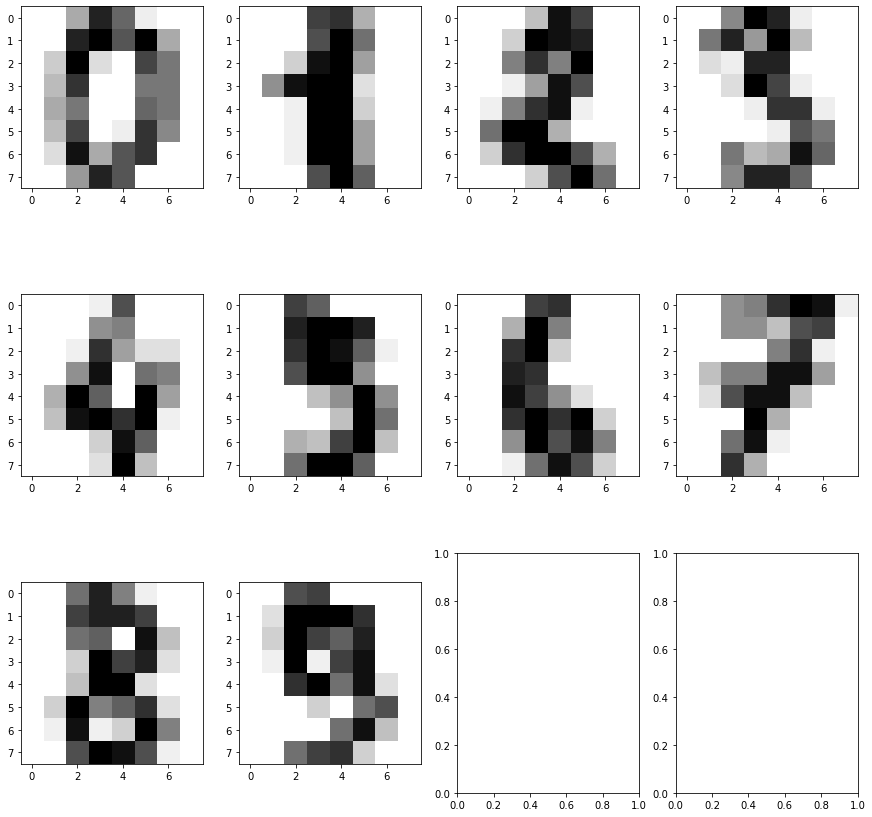

In [6]:
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axs[0, 0].imshow(16 - X[0,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 1].imshow(16 - X[1,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 2].imshow(16 - X[2,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 3].imshow(16 - X[3,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 0].imshow(16 - X[4,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 1].imshow(16 - X[5,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 2].imshow(16 - X[6,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 3].imshow(16 - X[7,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 0].imshow(16 - X[8,:].reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 1].imshow(16 - X[9,:].reshape((8, 8)), cmap='gray',interpolation=None)
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:
kmeans = KMeans(n_clusters=10, random_state=0,n_init=100)
km_clusters = kmeans.fit_predict(X)

In [8]:
km_clusters.shape

(1797,)

In [9]:
agglomerative = AgglomerativeClustering(n_clusters=10)
agglomerative_clusters = agglomerative.fit_predict(X)

In [10]:
agglomerative_clusters.shape

(1797,)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [43]:
X.shape

(1797, 64)

In [50]:
b = np.zeros((1797,65))

In [51]:
b.shape

(1797, 65)

In [74]:
b[:,:-1] = X
b[:,-1] = km_clusters

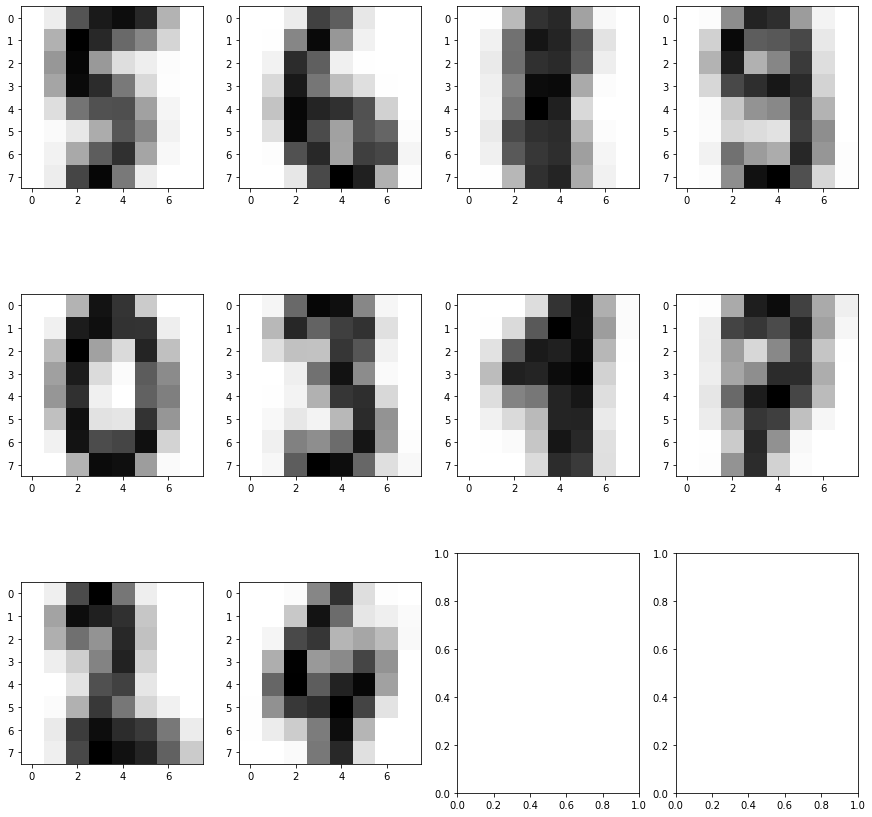

In [75]:
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axs[0, 0].imshow(16 - np.mean(b[b[:,-1] == 0][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 1].imshow(16 - np.mean(b[b[:,-1] == 1][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 2].imshow(16 - np.mean(b[b[:,-1] == 2][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 3].imshow(16 - np.mean(b[b[:,-1] == 3][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 0].imshow(16 - np.mean(b[b[:,-1] == 4][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 1].imshow(16 - np.mean(b[b[:,-1] == 5][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 2].imshow(16 - np.mean(b[b[:,-1] == 6][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 3].imshow(16 - np.mean(b[b[:,-1] == 7][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 0].imshow(16 - np.mean(b[b[:,-1] == 8][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 1].imshow(16 - np.mean(b[b[:,-1] == 9][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
plt.show()

7 из 10 цифр можно различить

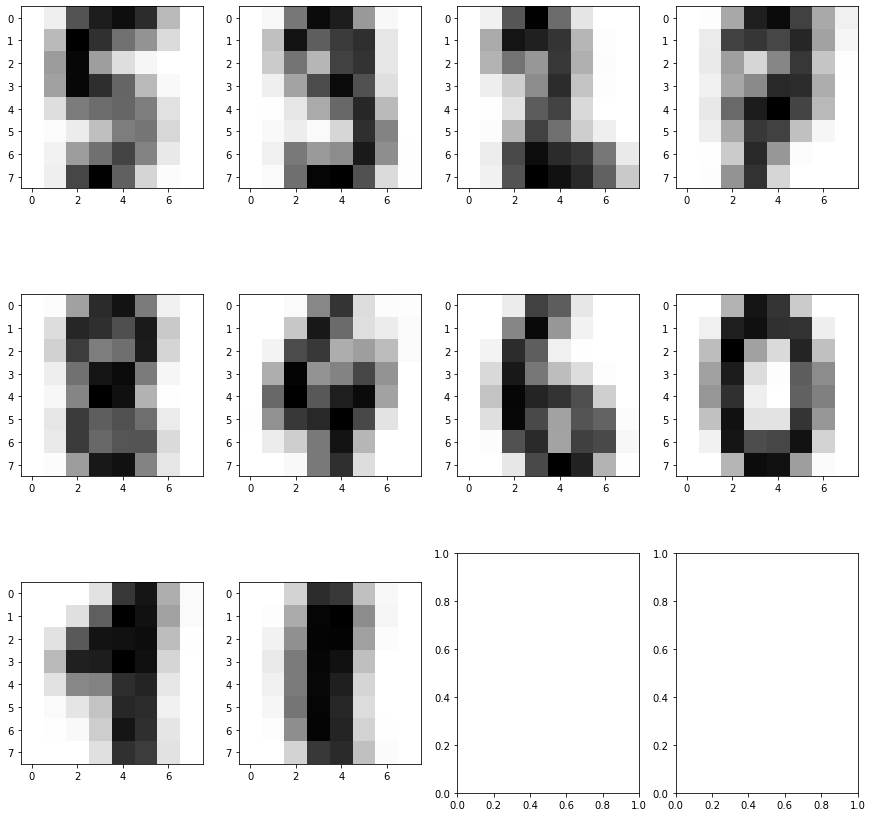

In [76]:
b[:,:-1] = X
b[:,-1] = agglomerative_clusters
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axs[0, 0].imshow(16 - np.mean(b[b[:,-1] == 0][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 1].imshow(16 - np.mean(b[b[:,-1] == 1][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 2].imshow(16 - np.mean(b[b[:,-1] == 2][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 3].imshow(16 - np.mean(b[b[:,-1] == 3][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 0].imshow(16 - np.mean(b[b[:,-1] == 4][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 1].imshow(16 - np.mean(b[b[:,-1] == 5][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 2].imshow(16 - np.mean(b[b[:,-1] == 6][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 3].imshow(16 - np.mean(b[b[:,-1] == 7][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 0].imshow(16 - np.mean(b[b[:,-1] == 8][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 1].imshow(16 - np.mean(b[b[:,-1] == 9][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
plt.show()

6 из 10 цифр можно различить

Алгоритм к-средних лучше в данном случае. 

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

For n_clusters = 2 The average silhouette_score is : 0.11832841100655983


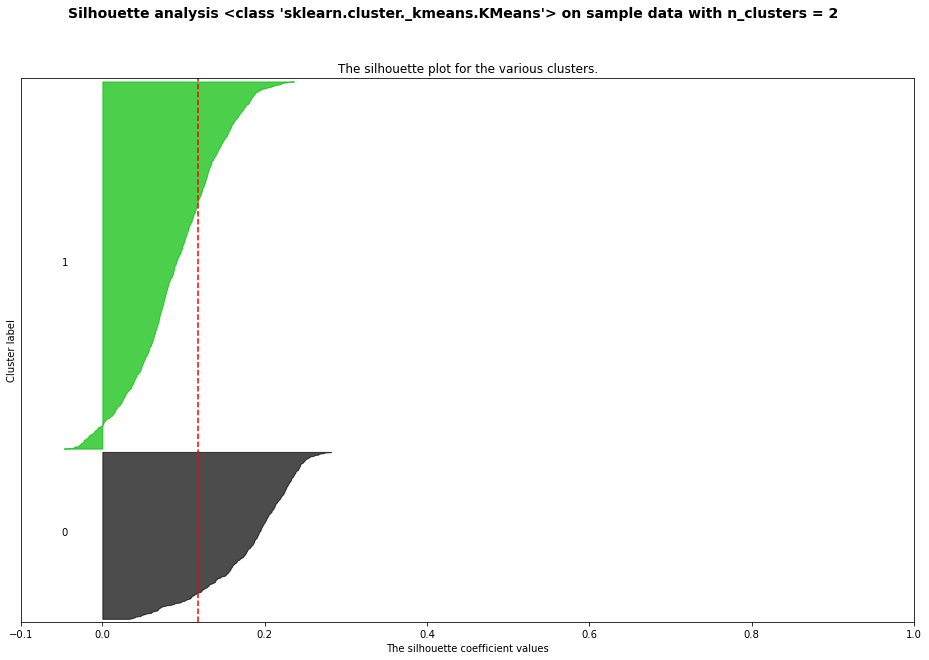

For n_clusters = 3 The average silhouette_score is : 0.1265024495405014


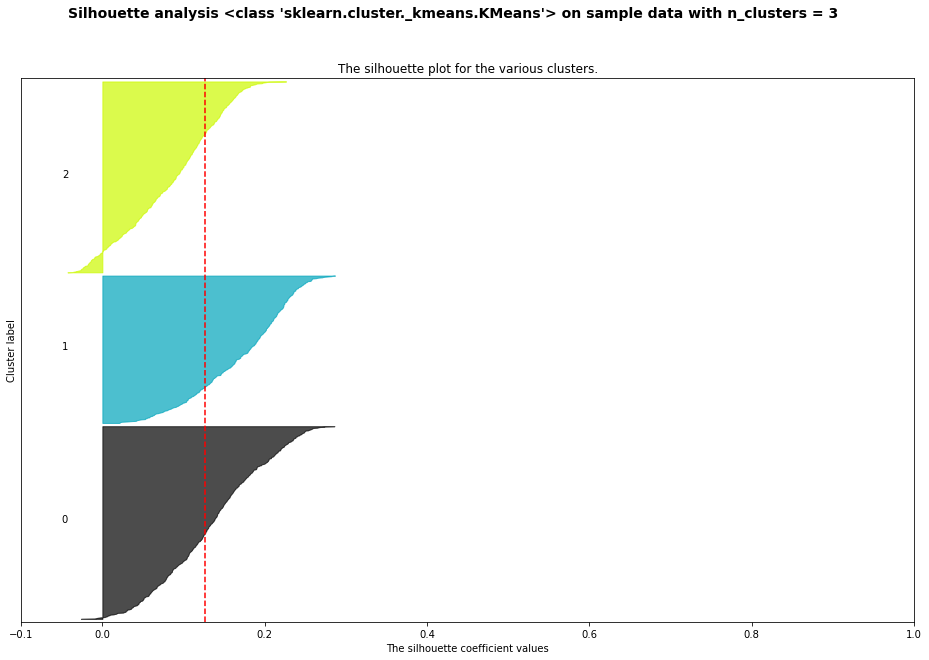

For n_clusters = 4 The average silhouette_score is : 0.1280949659249427


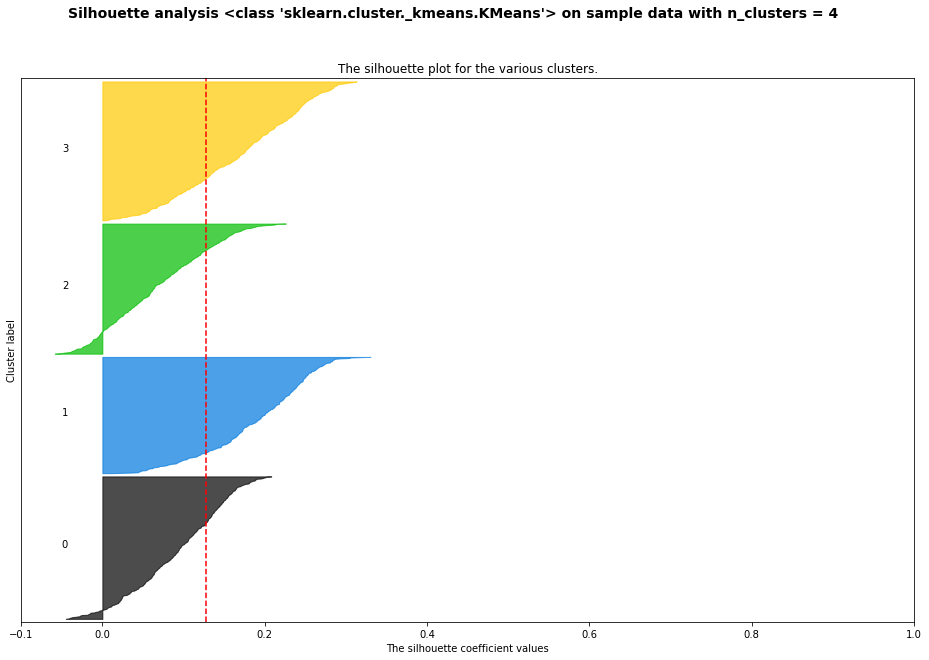

For n_clusters = 5 The average silhouette_score is : 0.13409045281103332


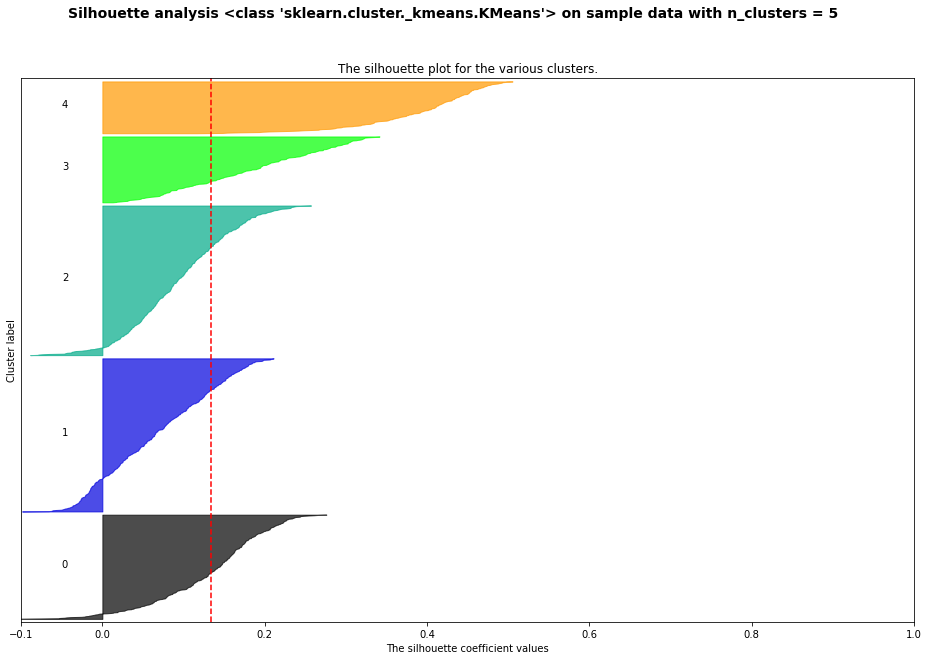

For n_clusters = 6 The average silhouette_score is : 0.15055644218997163


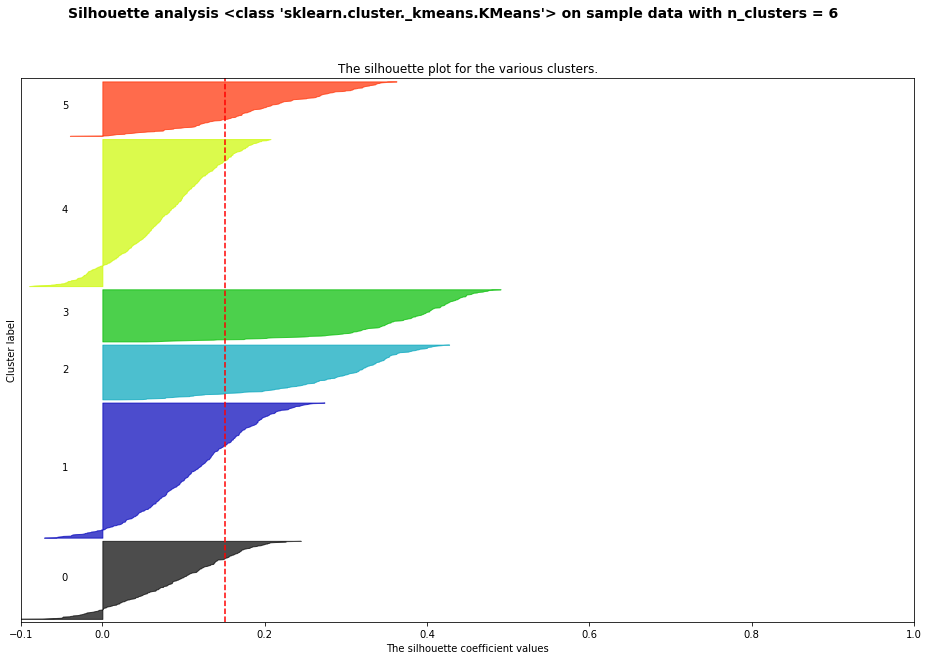

For n_clusters = 7 The average silhouette_score is : 0.16337788737586392


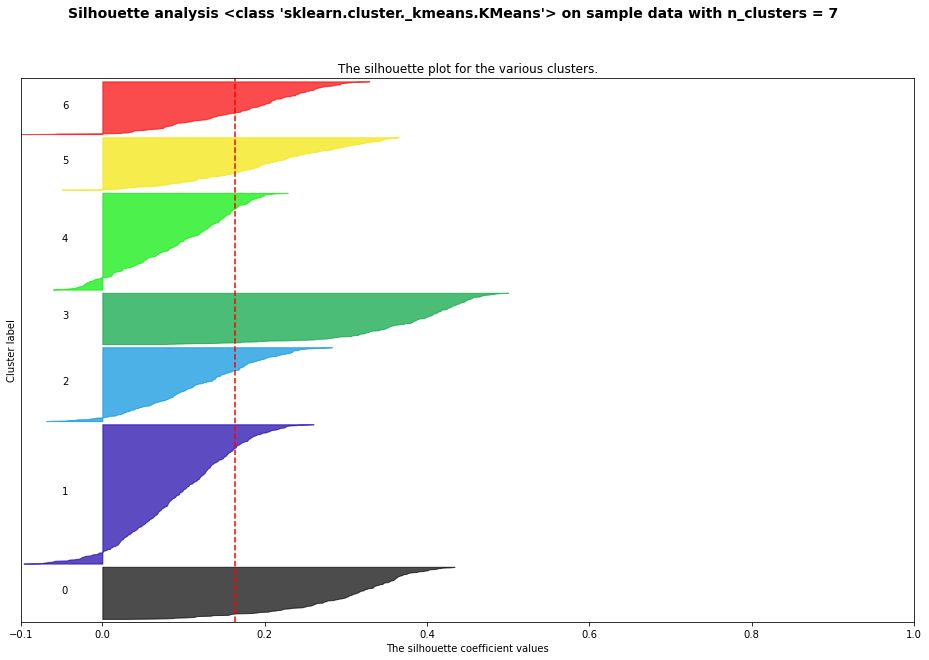

For n_clusters = 8 The average silhouette_score is : 0.17870607214004094


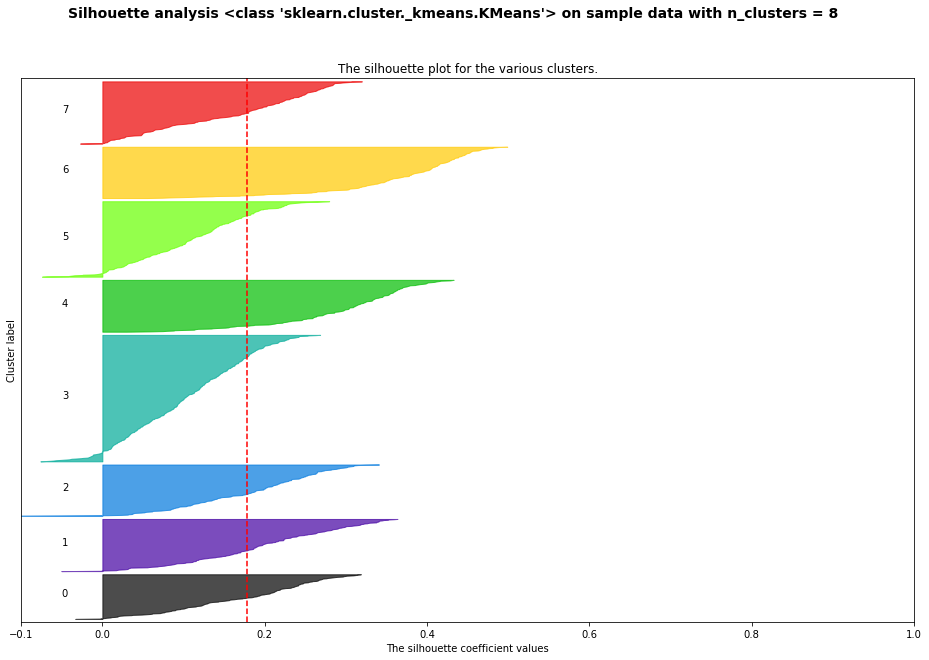

For n_clusters = 9 The average silhouette_score is : 0.1893118462275891


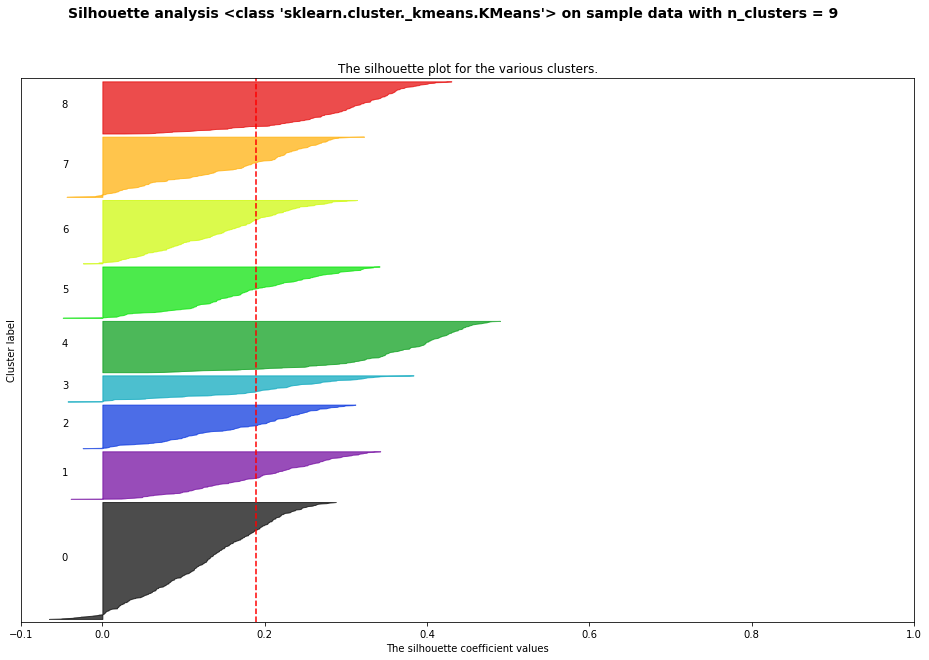

For n_clusters = 10 The average silhouette_score is : 0.18230452089352572


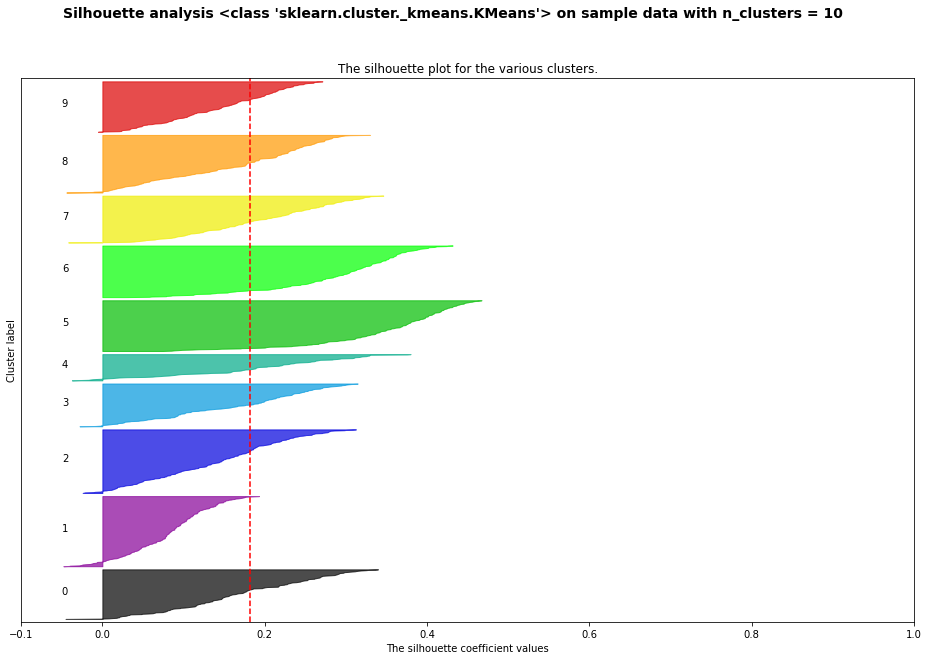

For n_clusters = 11 The average silhouette_score is : 0.18280635217567176


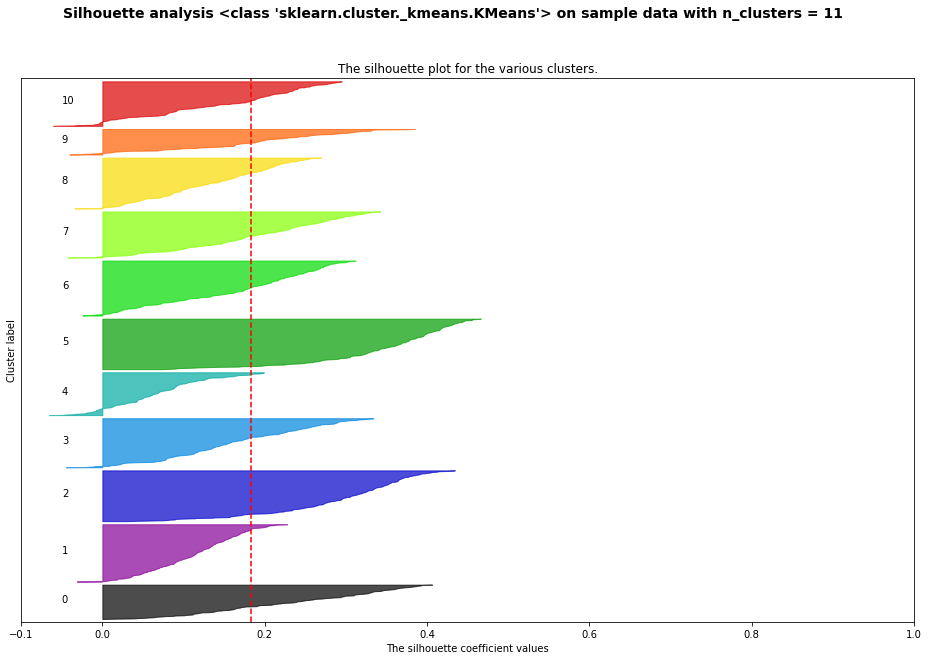

For n_clusters = 12 The average silhouette_score is : 0.1827744612158504


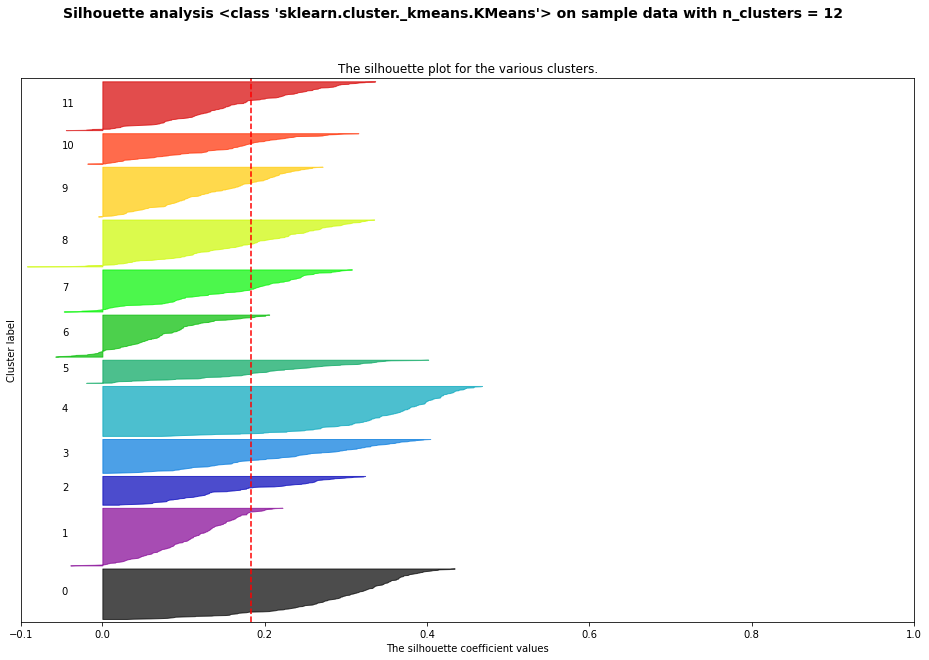

For n_clusters = 13 The average silhouette_score is : 0.18518572807087913


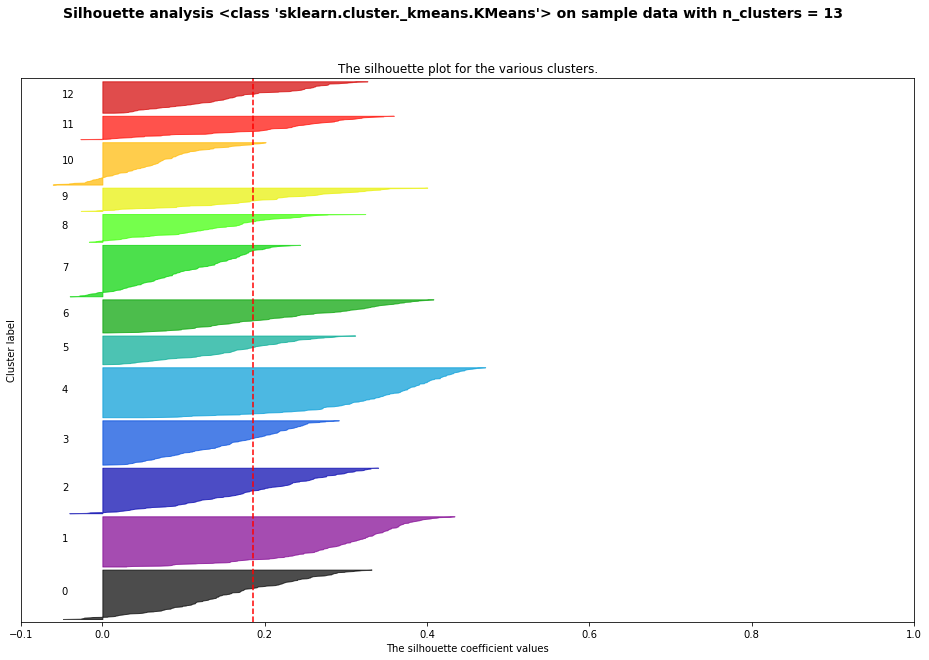

For n_clusters = 14 The average silhouette_score is : 0.18834498615534023


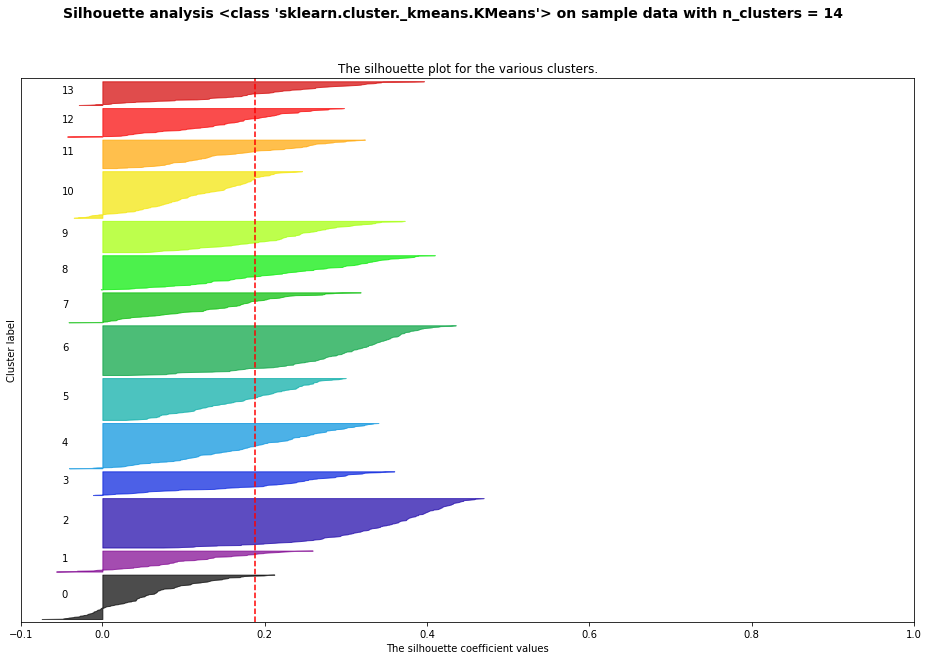

For n_clusters = 15 The average silhouette_score is : 0.18632952196073874


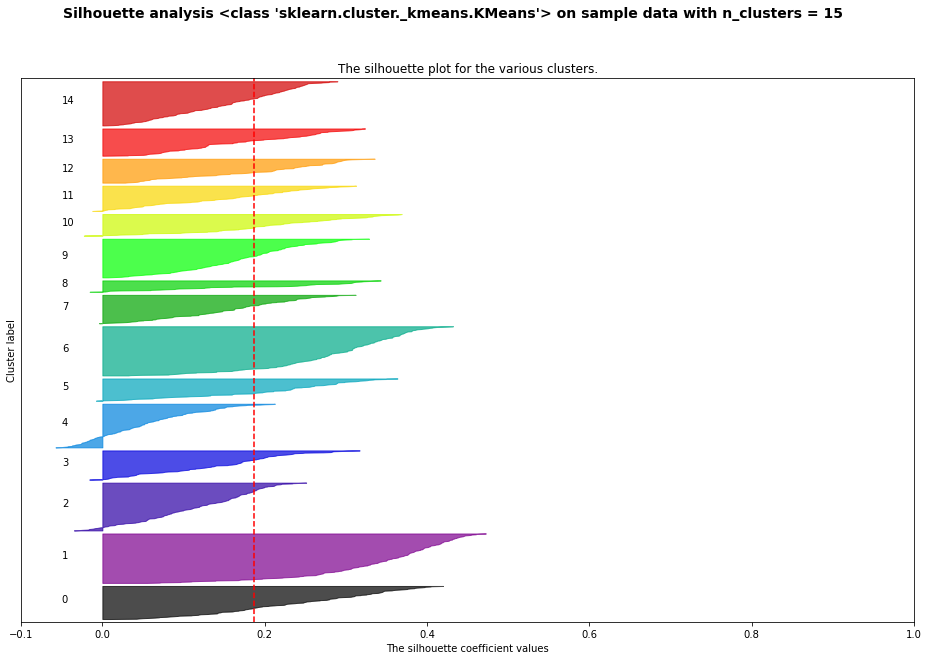

For n_clusters = 16 The average silhouette_score is : 0.18092865862953236


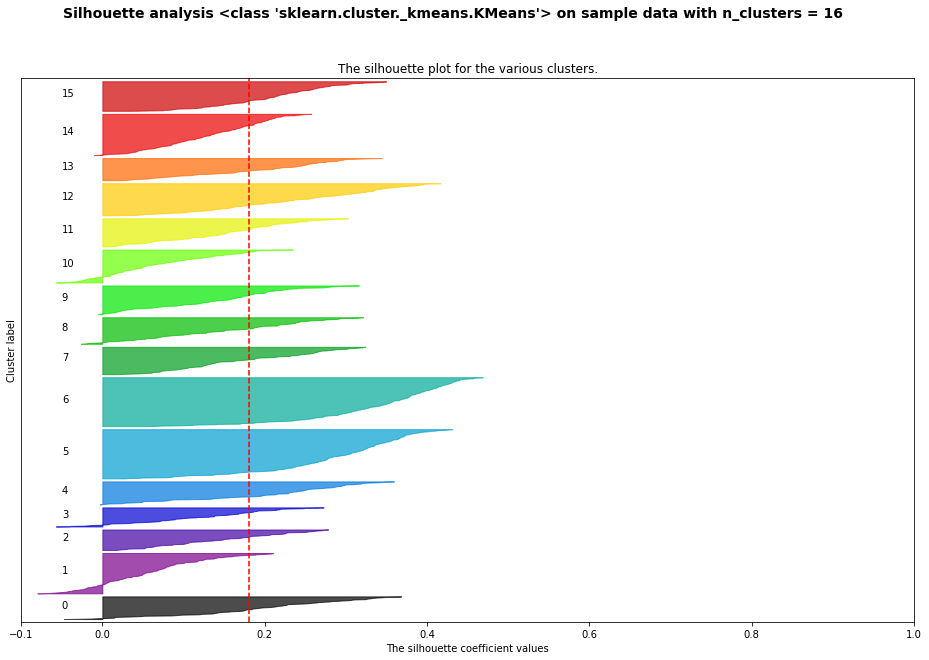

For n_clusters = 17 The average silhouette_score is : 0.18717947886478872


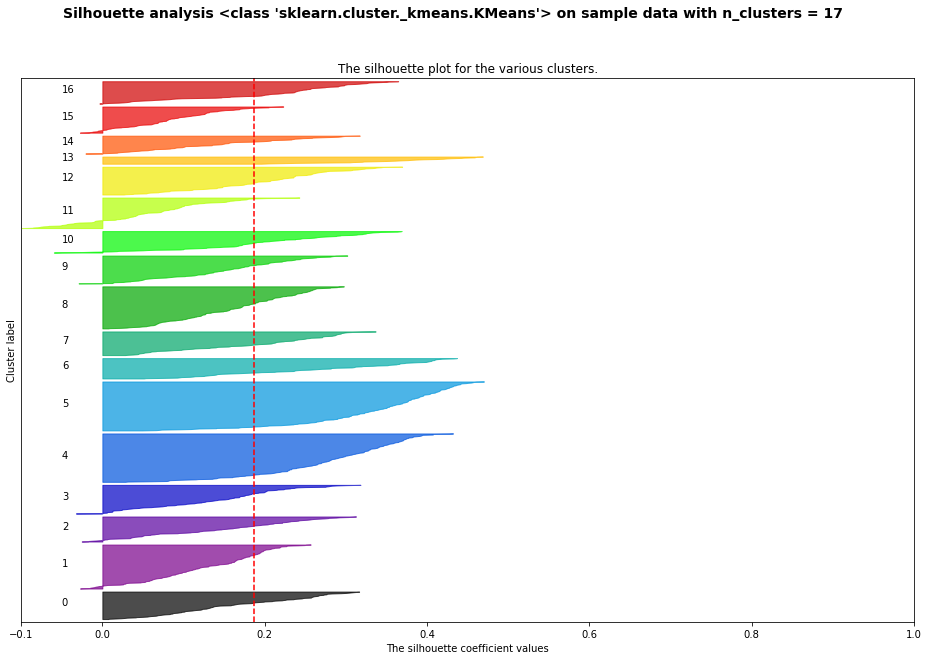

For n_clusters = 18 The average silhouette_score is : 0.19109916426942733


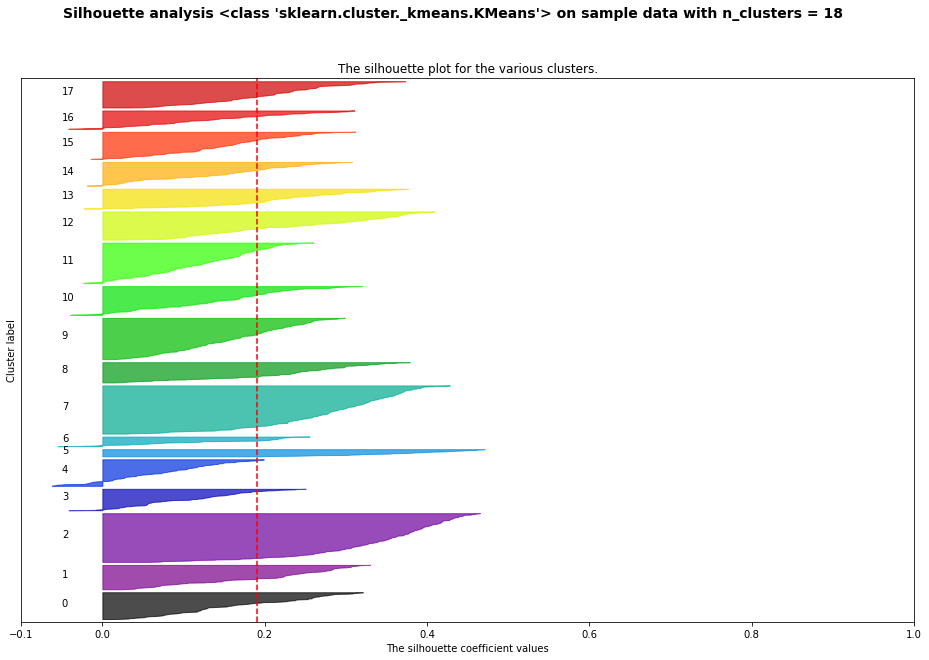

For n_clusters = 19 The average silhouette_score is : 0.17331502012179234


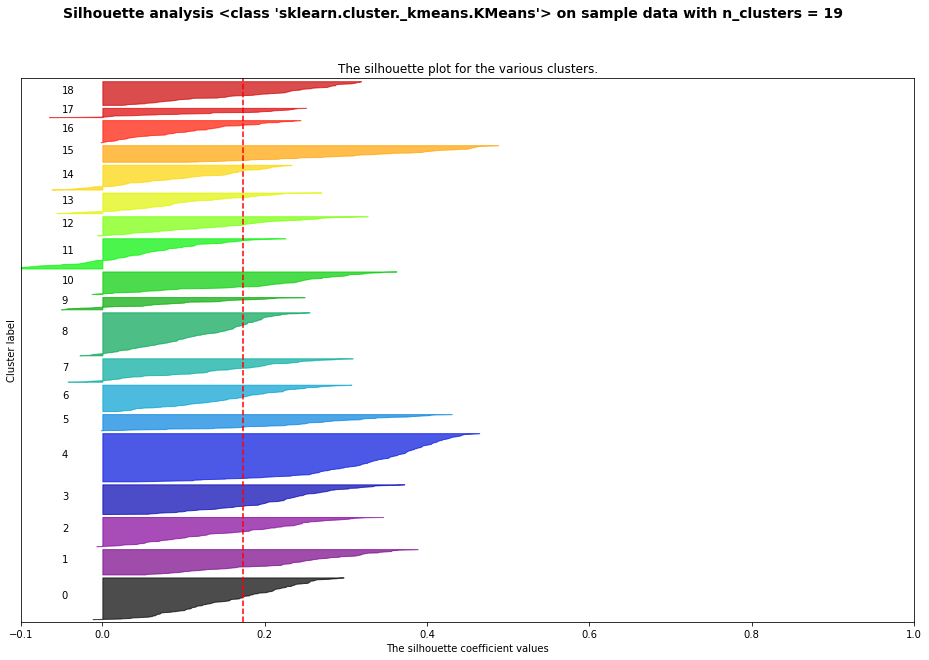

For n_clusters = 20 The average silhouette_score is : 0.1710661887510825


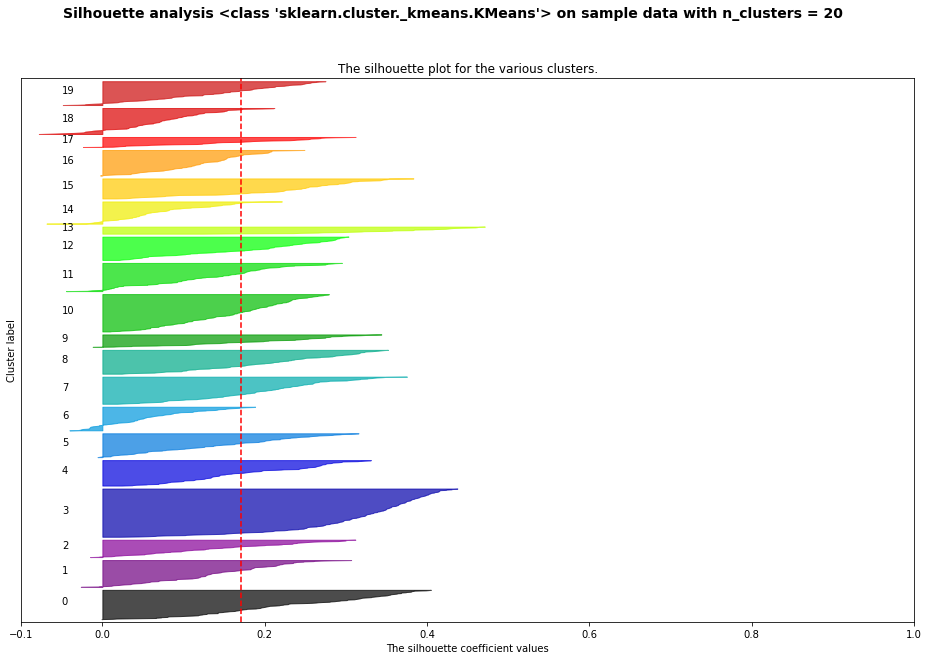

In [40]:
# функция для этого задания находится сверху, сразу после импортов
siluette_plot(KMeans,X,list(range(2,21)))

Для к-средних максимум достигается при 18 кластерах. 

For n_clusters = 2 The average silhouette_score is : 0.11674033985112256


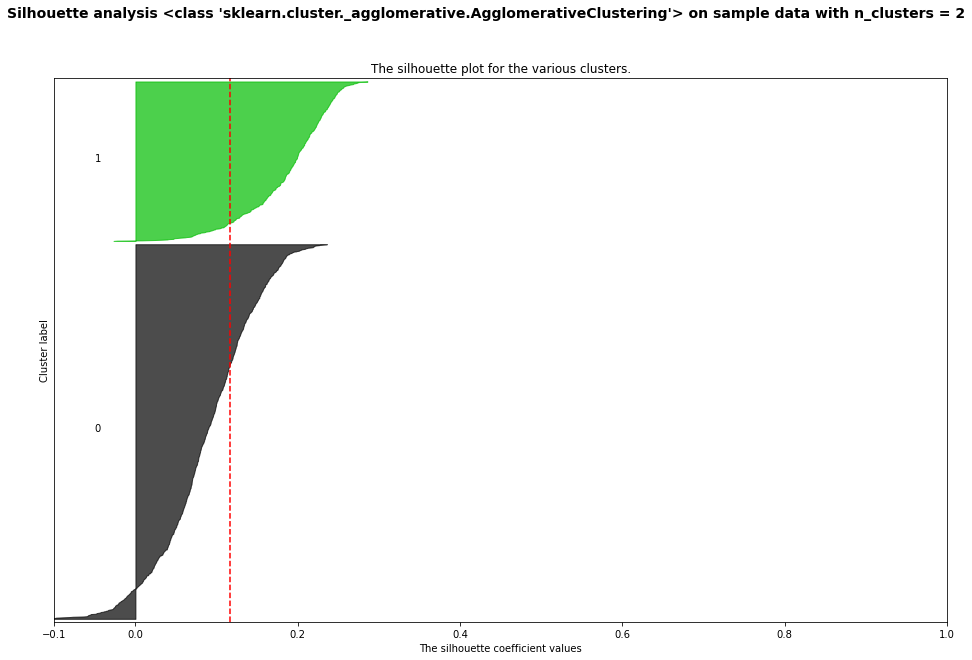

For n_clusters = 3 The average silhouette_score is : 0.11188954666963648


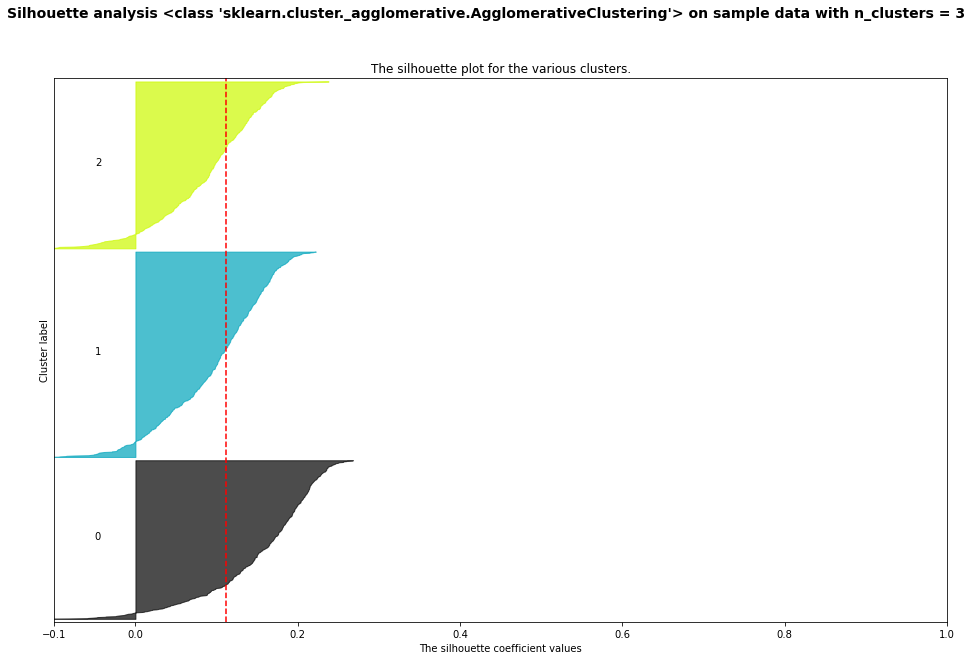

For n_clusters = 4 The average silhouette_score is : 0.10895989445239453


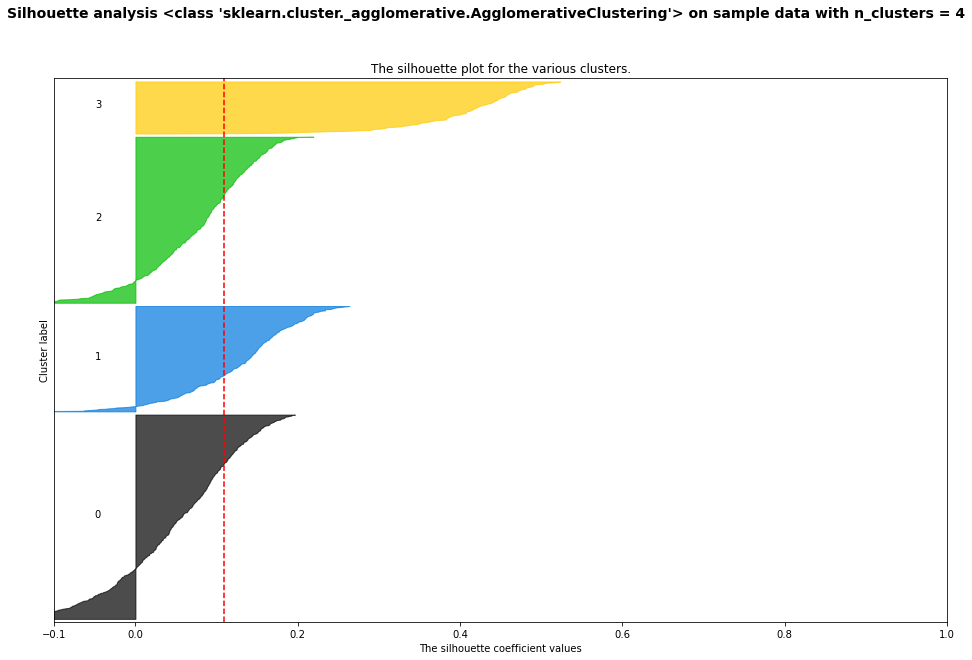

For n_clusters = 5 The average silhouette_score is : 0.11888125787404626


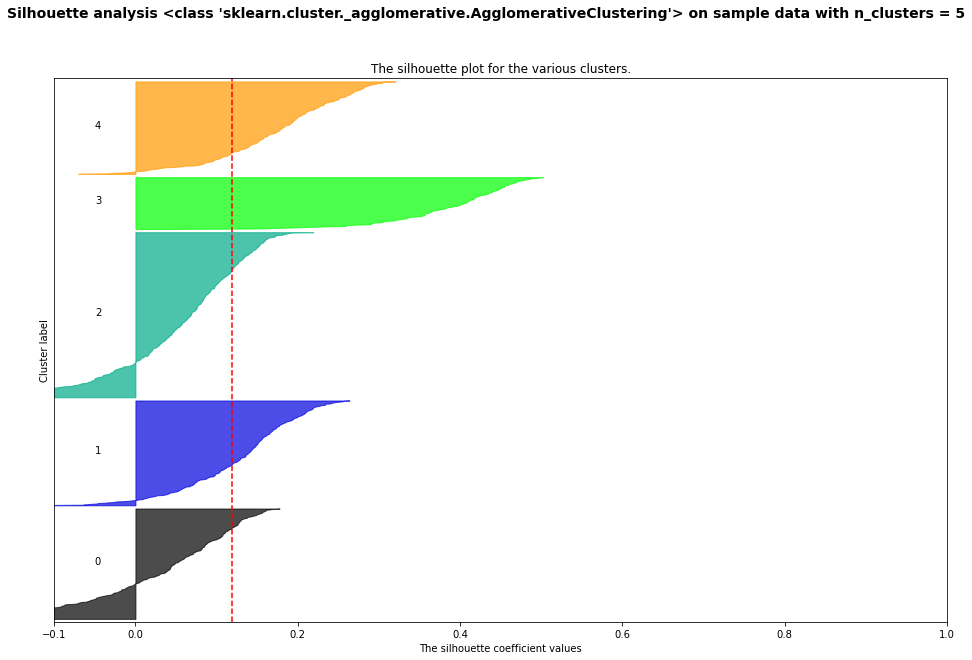

For n_clusters = 6 The average silhouette_score is : 0.13701122727669246


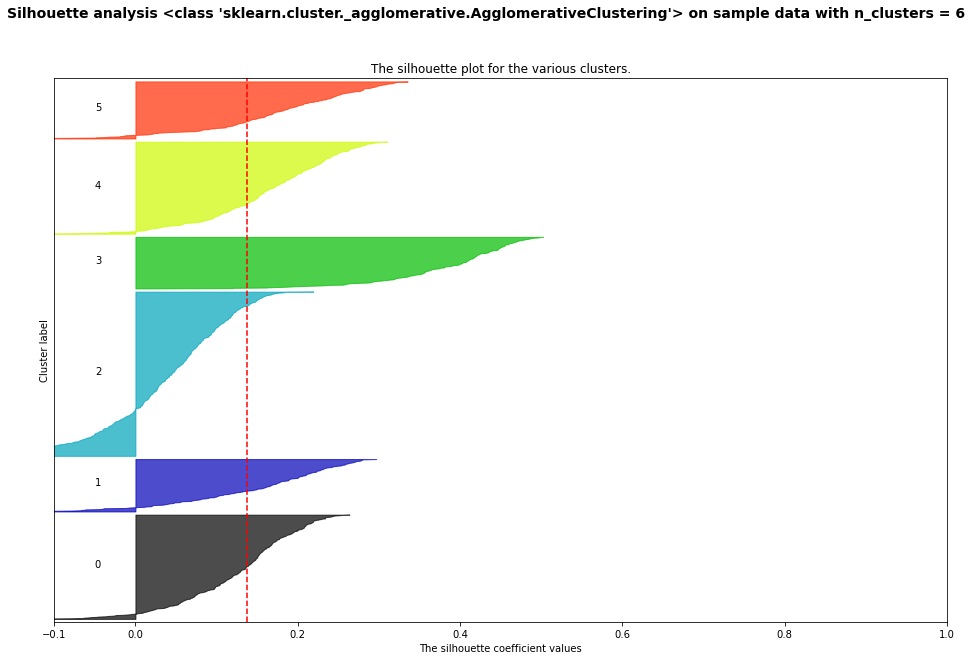

For n_clusters = 7 The average silhouette_score is : 0.15368571066948947


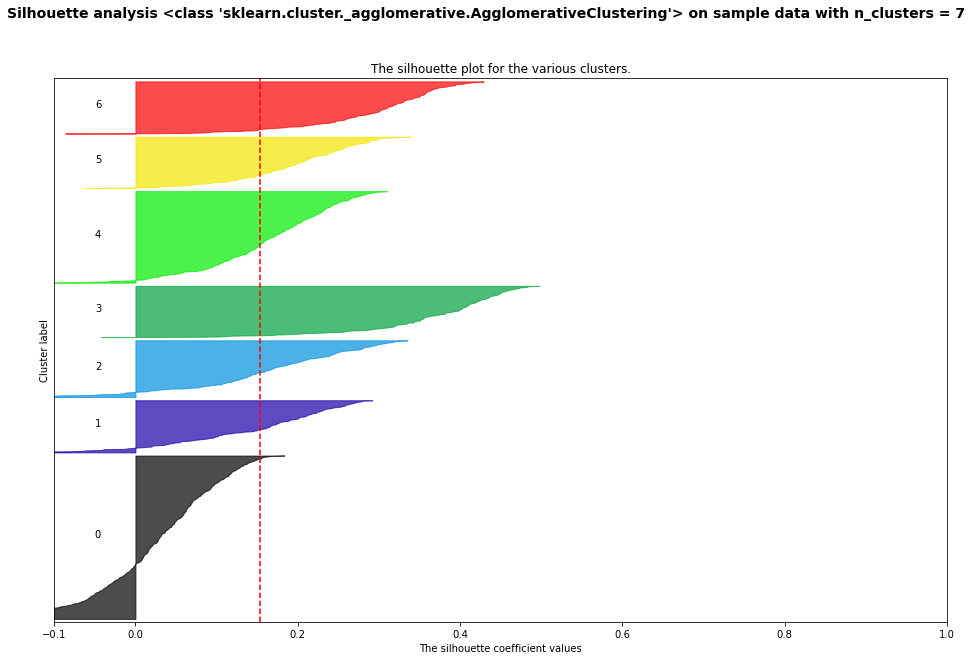

For n_clusters = 8 The average silhouette_score is : 0.17056308645095428


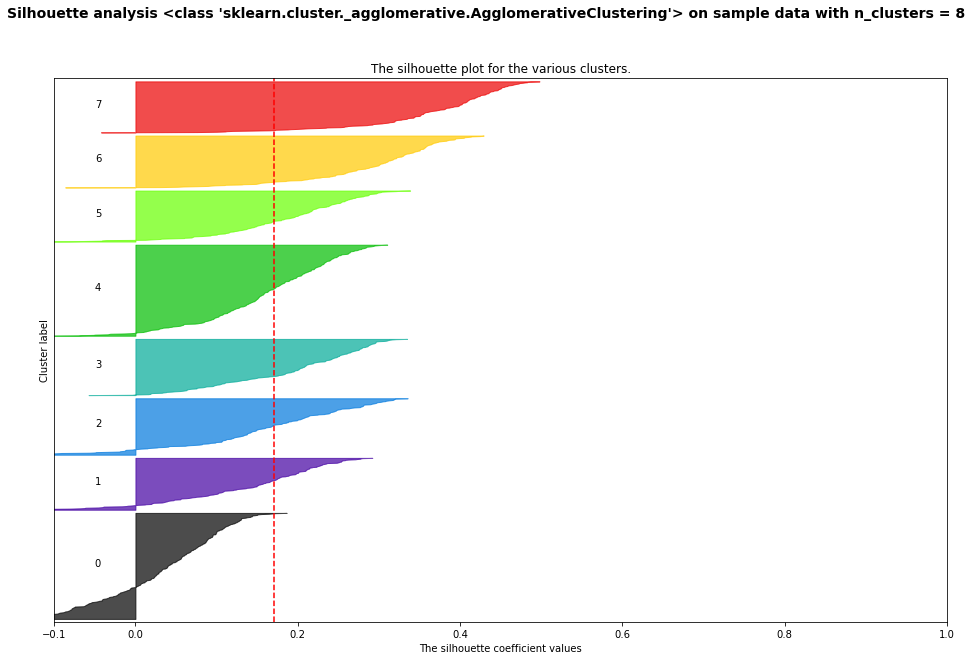

For n_clusters = 9 The average silhouette_score is : 0.18061975703867697


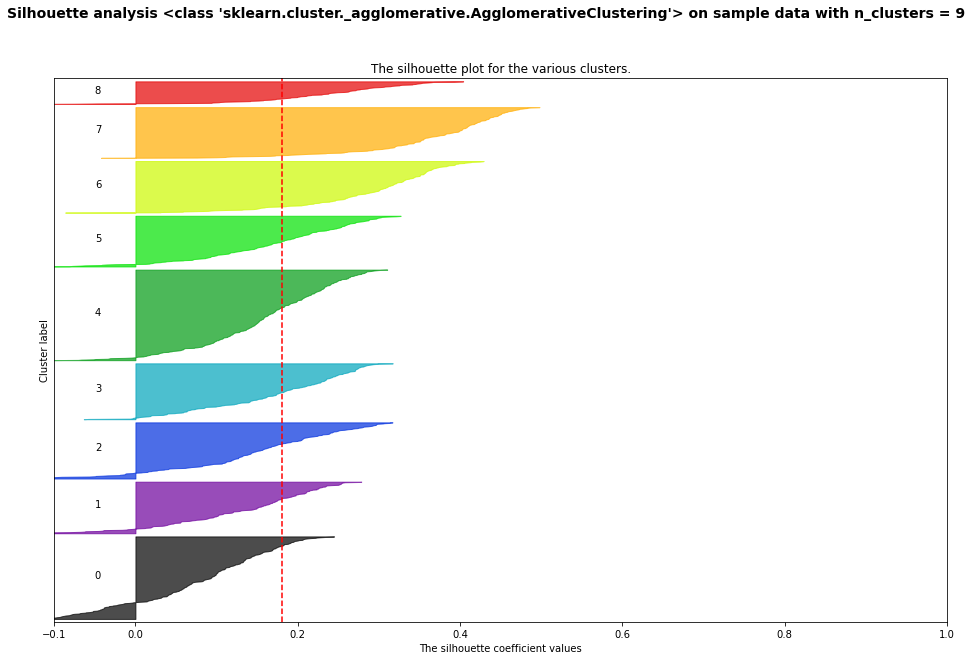

For n_clusters = 10 The average silhouette_score is : 0.17849659940596496


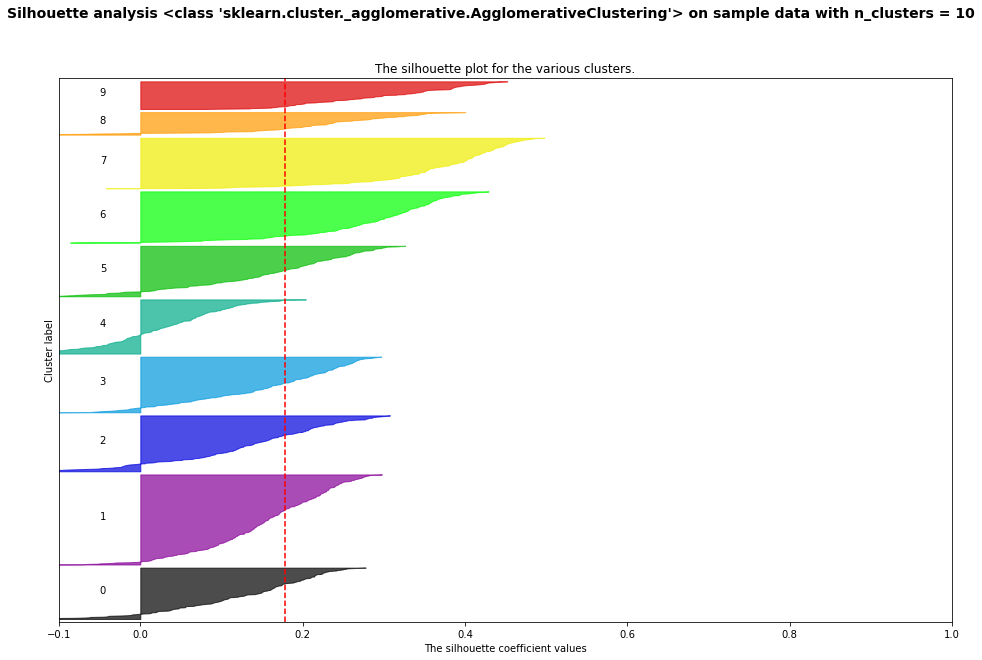

For n_clusters = 11 The average silhouette_score is : 0.17637337987696772


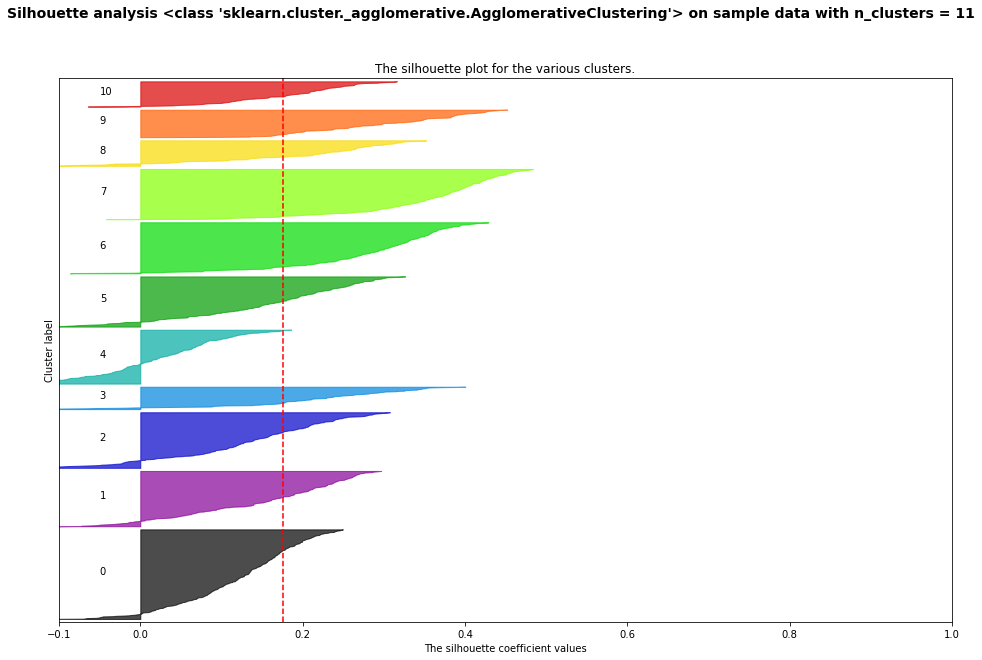

For n_clusters = 12 The average silhouette_score is : 0.17362319379744087


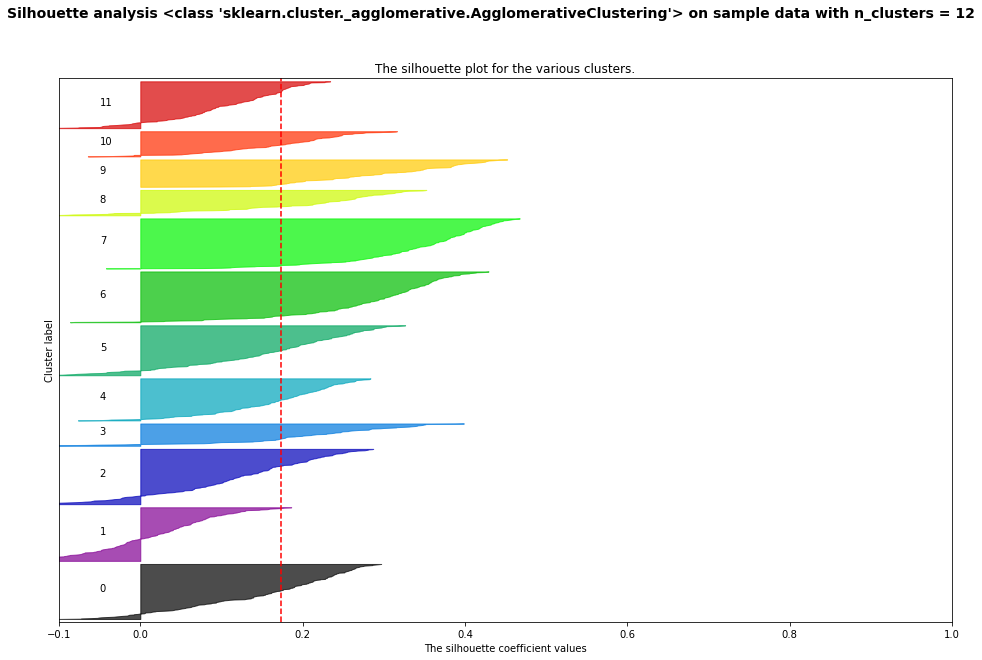

For n_clusters = 13 The average silhouette_score is : 0.1726407155529682


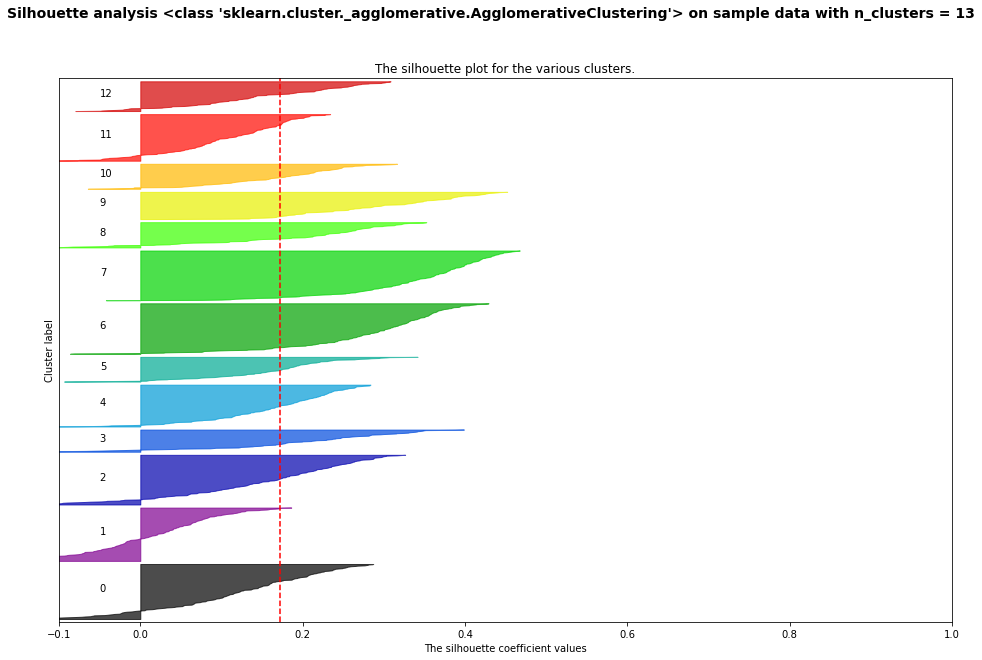

For n_clusters = 14 The average silhouette_score is : 0.17670992249010575


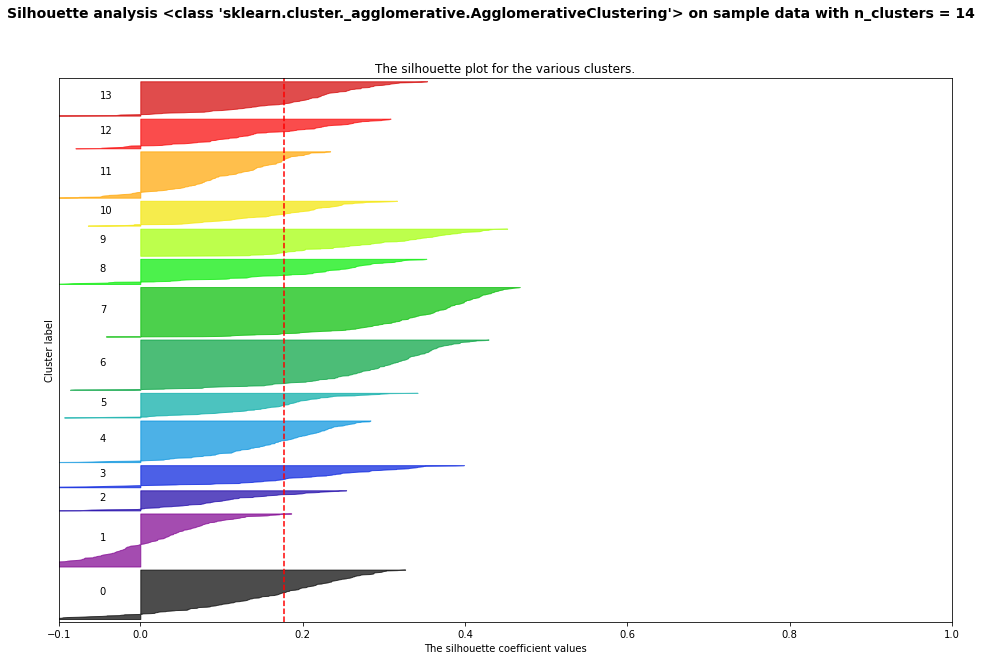

For n_clusters = 15 The average silhouette_score is : 0.17633457435967023


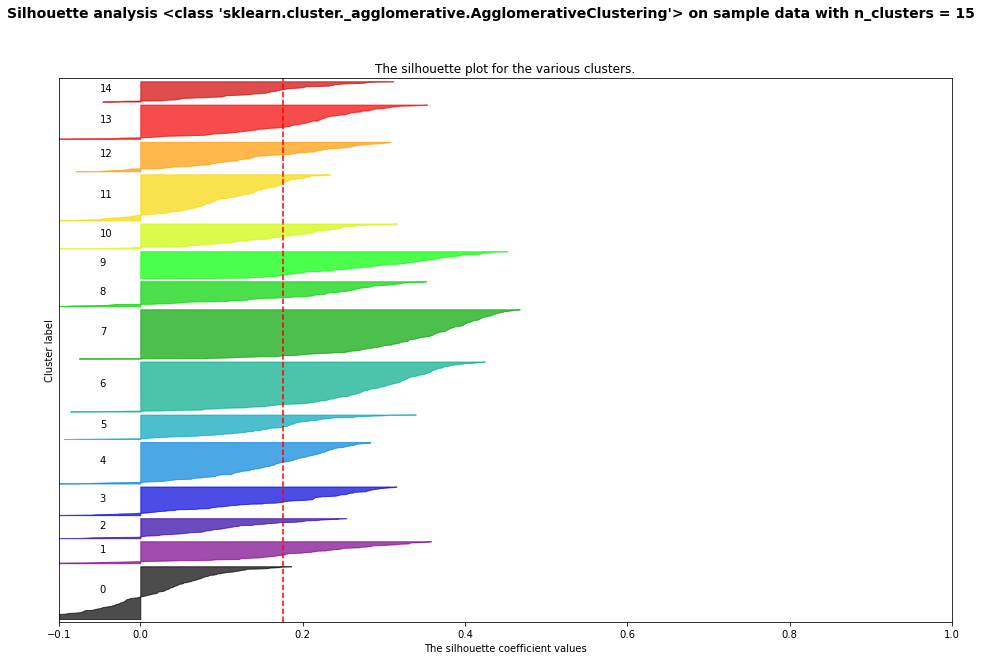

For n_clusters = 16 The average silhouette_score is : 0.17695214651125427


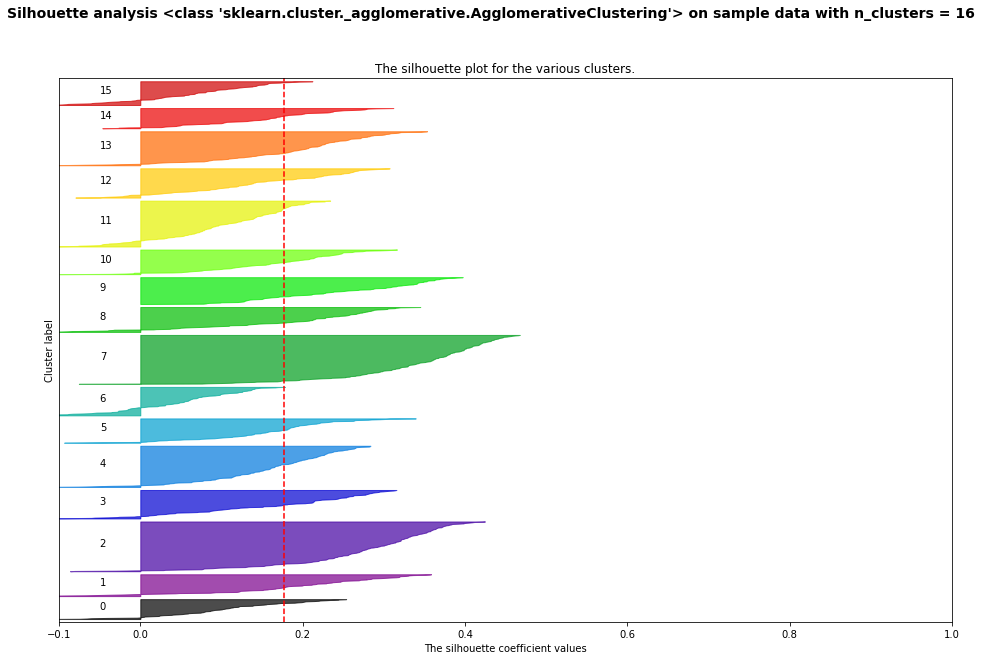

For n_clusters = 17 The average silhouette_score is : 0.17953047348045556


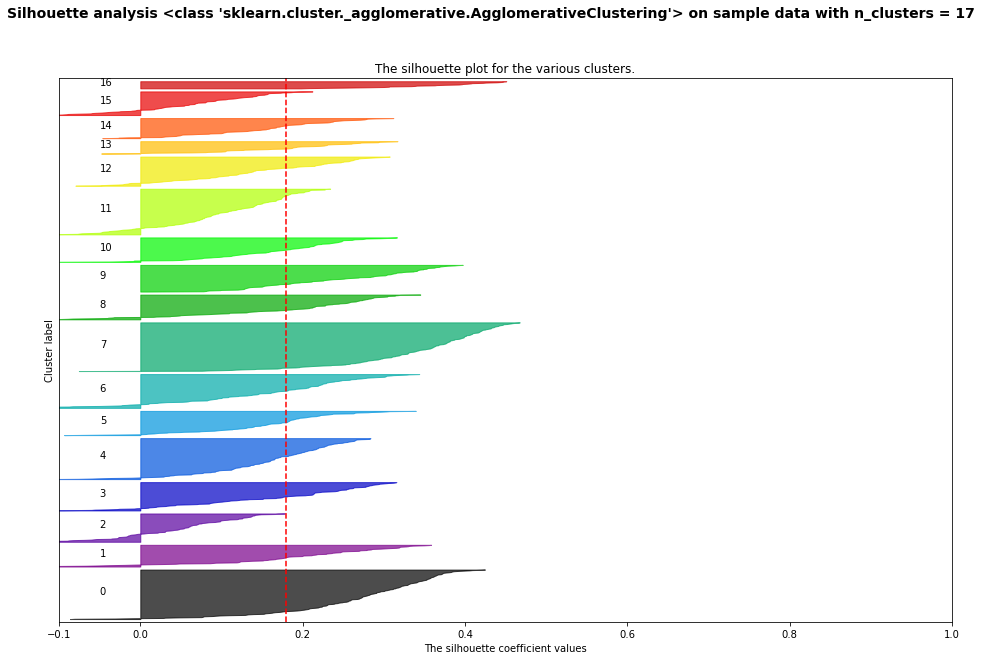

For n_clusters = 18 The average silhouette_score is : 0.1669829287095671


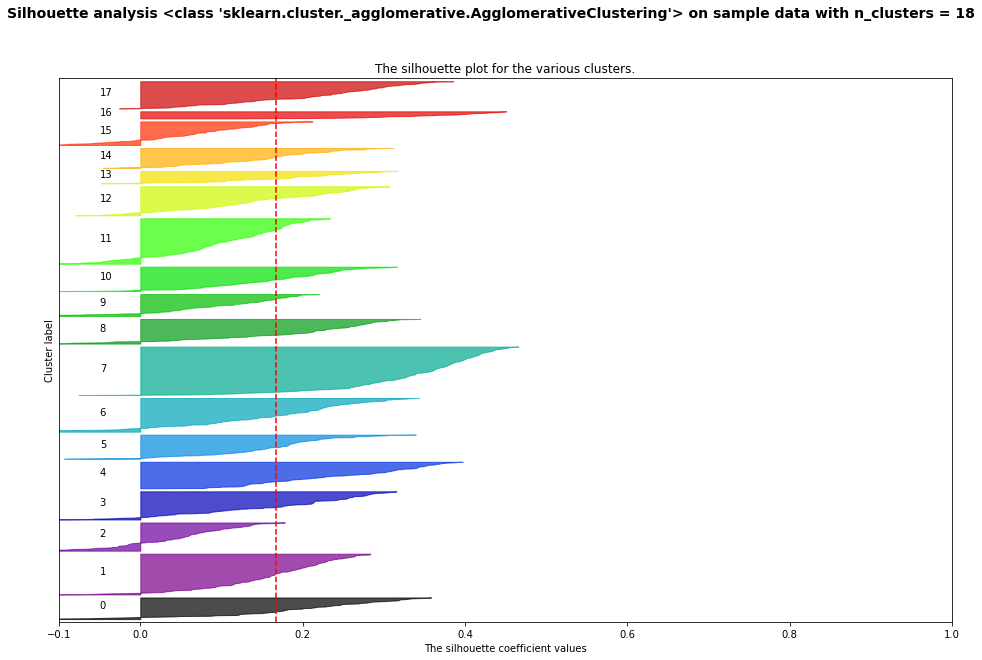

For n_clusters = 19 The average silhouette_score is : 0.16585394177607718


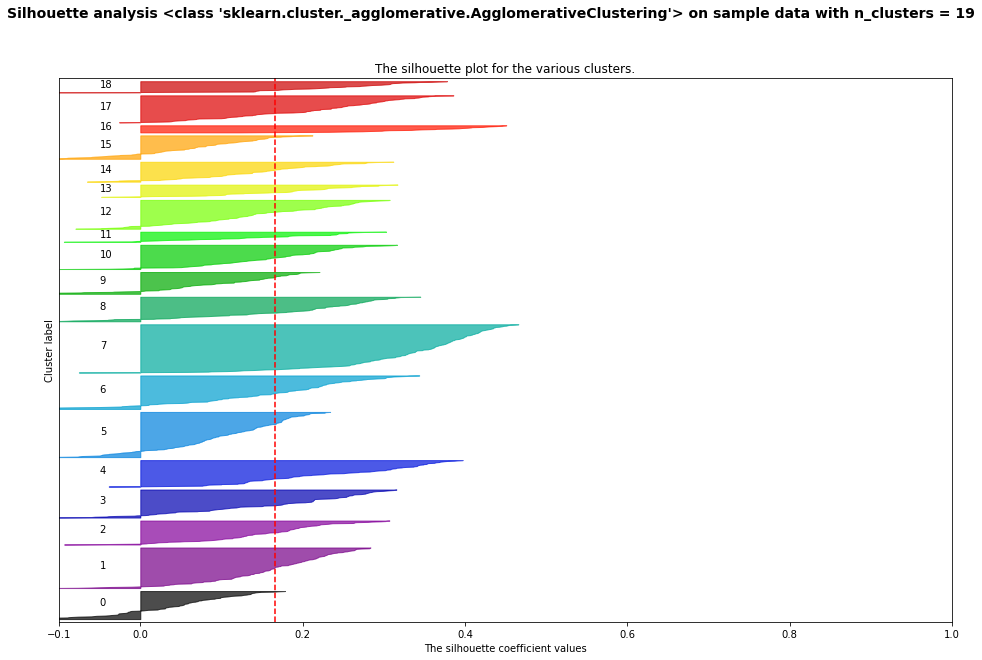

For n_clusters = 20 The average silhouette_score is : 0.1686039123227311


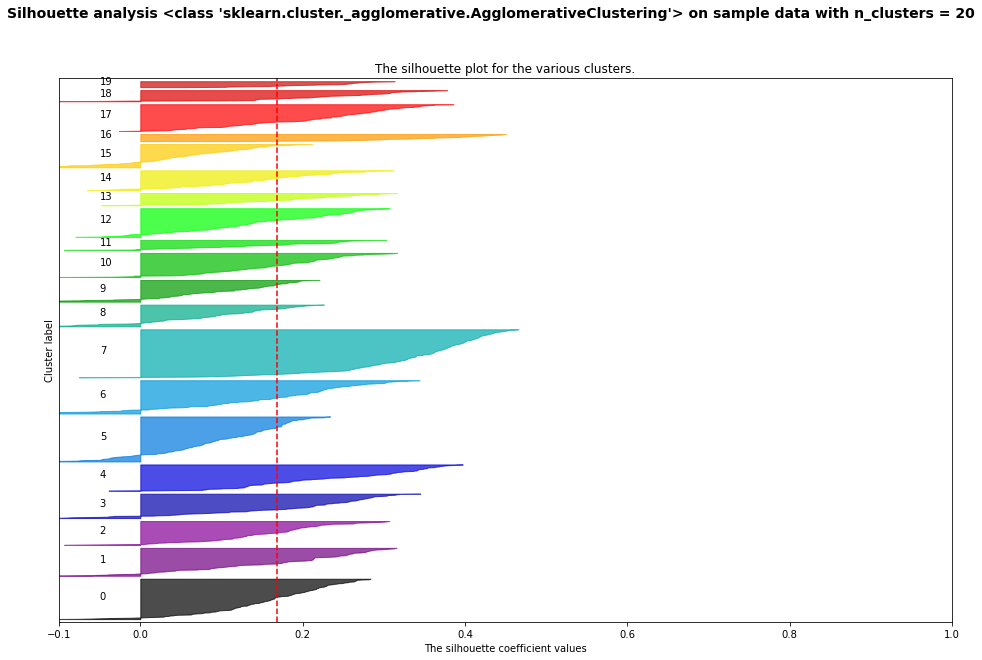

In [12]:
siluette_plot(AgglomerativeClustering,X,list(range(2,21)))

Для иерархической кластеризации максимум достигается при 9 кластерах. 

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

Score for 2 clusters is (0.22857707086928197, 0.8471148027985769, 0.36001205373704537)
Score for 3 clusters is (0.29784084997924726, 0.6283403326492359, 0.4041226970761305)
Score for 4 clusters is (0.3625584292239796, 0.6054903236358711, 0.45354248946493353)
Score for 5 clusters is (0.48717486514263925, 0.7200934916124022, 0.5811656500453528)
Score for 6 clusters is (0.5226885065331172, 0.6931046935885036, 0.5959530899278407)
Score for 7 clusters is (0.5973249115529027, 0.7361160689701792, 0.6594974538997551)
Score for 8 clusters is (0.6717584657929081, 0.7673732307359756, 0.7163895638086244)
Score for 9 clusters is (0.6918485291918983, 0.7499179483327382, 0.7197138200346945)
Score for 10 clusters is (0.7388460983915266, 0.7474699643546284, 0.7431330127831512)
Score for 11 clusters is (0.7843473849430159, 0.7598373537991696, 0.77189785196278)
Score for 12 clusters is (0.8147654027066981, 0.7662680146522045, 0.7897728924443596)
Score for 13 clusters is (0.814376432628561, 0.740761002238

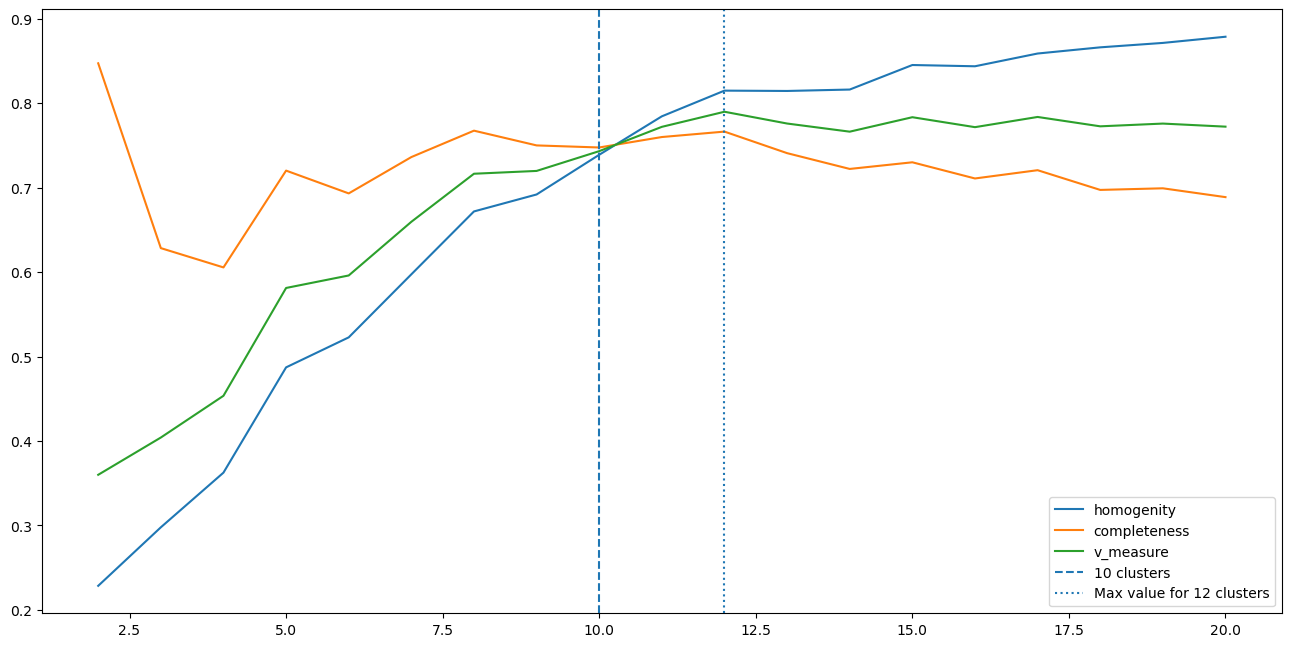

In [13]:
# функция представленна в начале ноутбука
v_measure_plot(KMeans,X,range(2,21))

Score for 2 clusters is (0.25818781836327476, 0.9747507265121849, 0.4082421862342204)
Score for 3 clusters is (0.4010642254118018, 0.8455303836343862, 0.5440613747462535)
Score for 4 clusters is (0.4835068162981168, 0.8684028684518593, 0.6211638409365545)
Score for 5 clusters is (0.5934689370160313, 0.8824033881411134, 0.7096535274129379)
Score for 6 clusters is (0.6567118180411371, 0.8925109210106364, 0.7566664944734938)
Score for 7 clusters is (0.7168505456784067, 0.9006324452589326, 0.7983006479287975)
Score for 8 clusters is (0.7967592672715788, 0.9012216228874104, 0.8457771039270549)
Score for 9 clusters is (0.8153989666761196, 0.8760988530159932, 0.8446597933958961)
Score for 10 clusters is (0.8575128719504723, 0.8790955851724198, 0.8681701126909083)
Score for 11 clusters is (0.8578479309824636, 0.852926157305002, 0.8553799643497675)
Score for 12 clusters is (0.8940692798486458, 0.8444447192471728, 0.86854875186737)
Score for 13 clusters is (0.8963306005501225, 0.8212661236061748

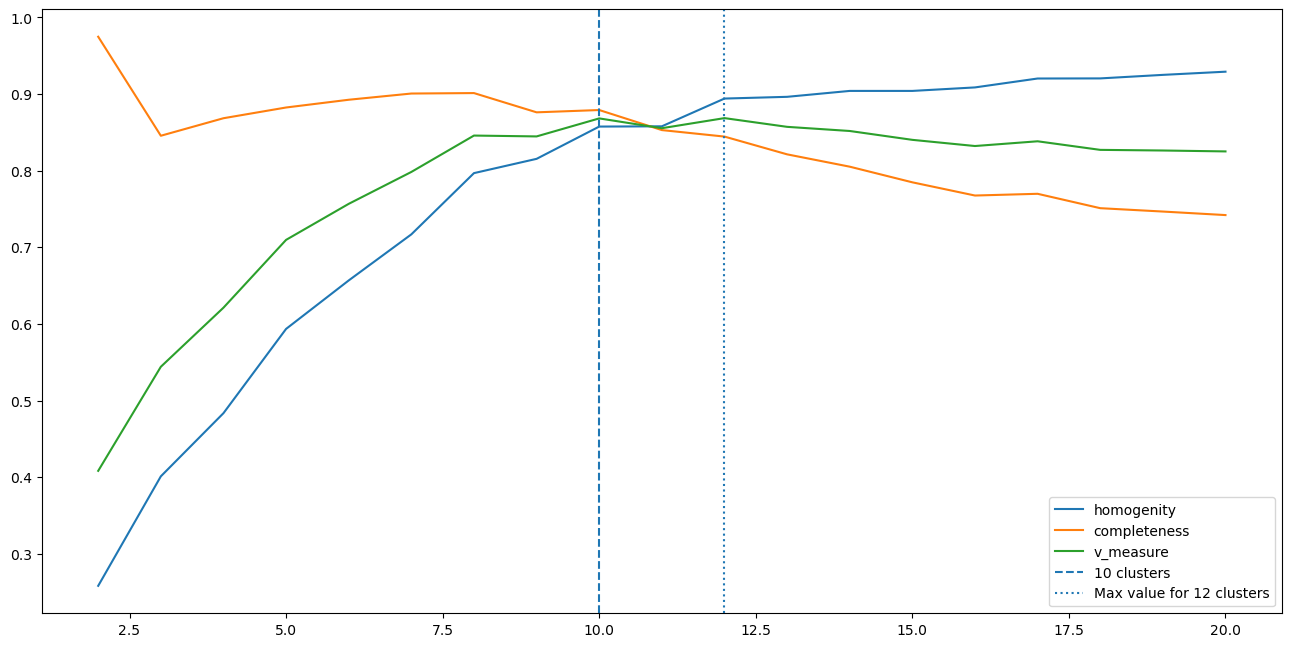

In [14]:
v_measure_plot(AgglomerativeClustering,X,range(2,21))

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

n_componenents = 2
homogeneity_completeness_v_measure: (0.34632020205839886, 0.3514386142010654, 0.3488606350649913)
For n_clusters = 10 The average silhouette_score is : 0.348530500873873


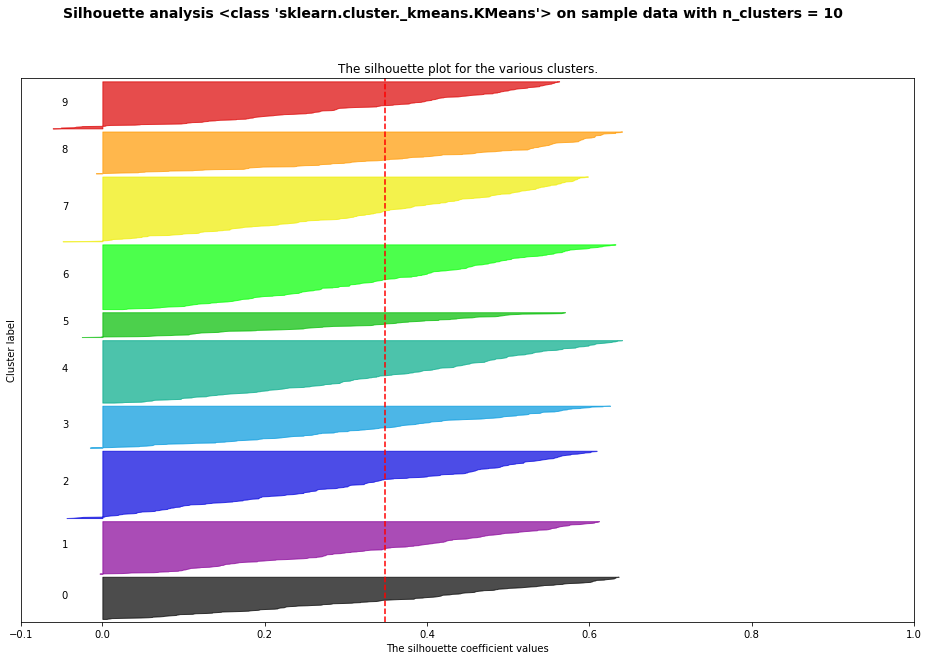



n_componenents = 5
homogeneity_completeness_v_measure: (0.6266929616803419, 0.6383766001005017, 0.6324808283605148)
For n_clusters = 10 The average silhouette_score is : 0.3121340878404604


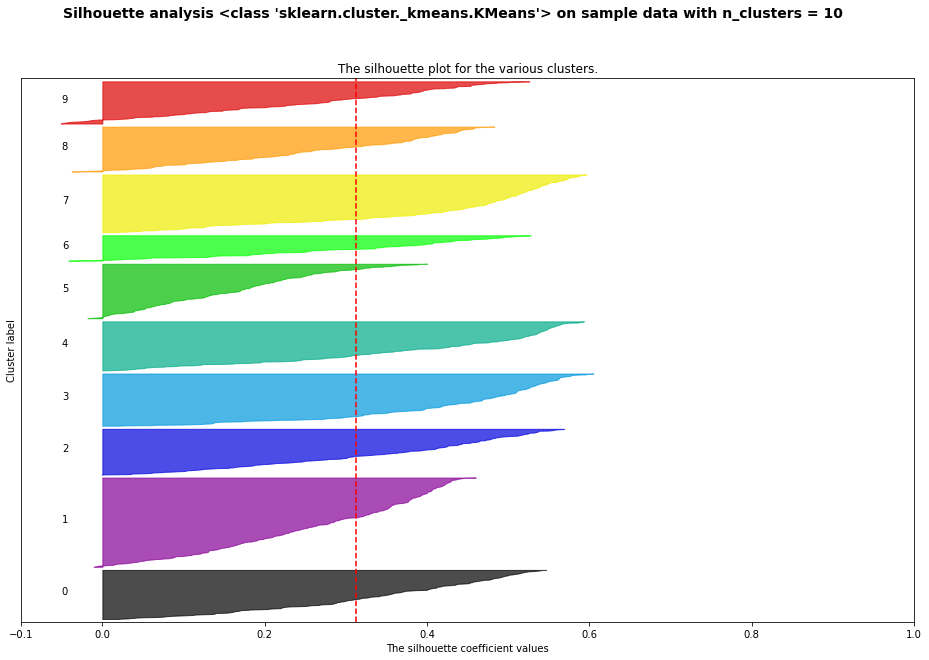



n_componenents = 10
homogeneity_completeness_v_measure: (0.7184163193376599, 0.7259376675230387, 0.7221574100459989)
For n_clusters = 10 The average silhouette_score is : 0.2630942197154966


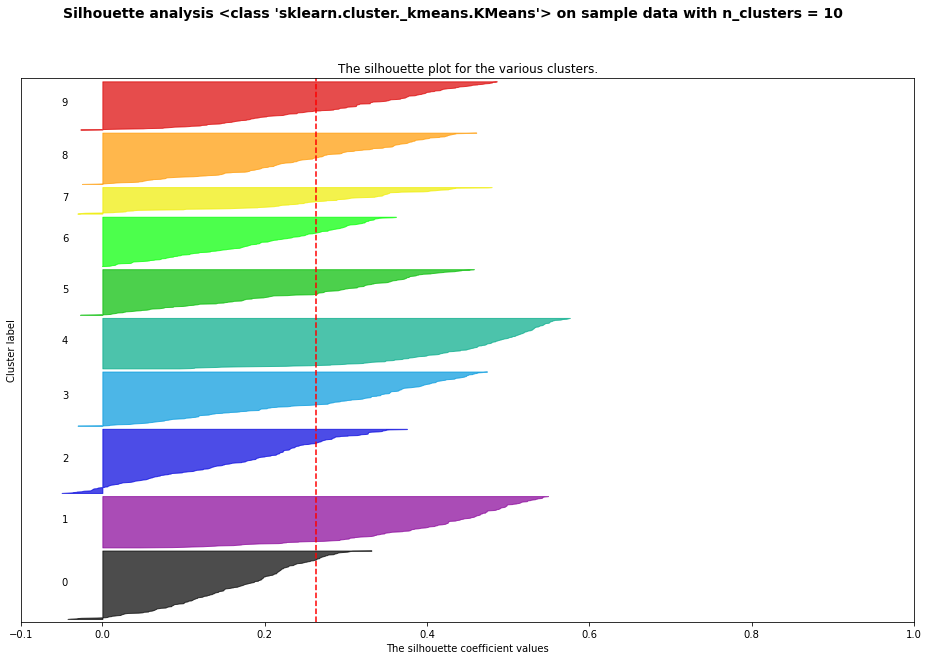



n_componenents = 20
homogeneity_completeness_v_measure: (0.7377436978391759, 0.7460456700754082, 0.7418714587123545)
For n_clusters = 10 The average silhouette_score is : 0.21263683472366354


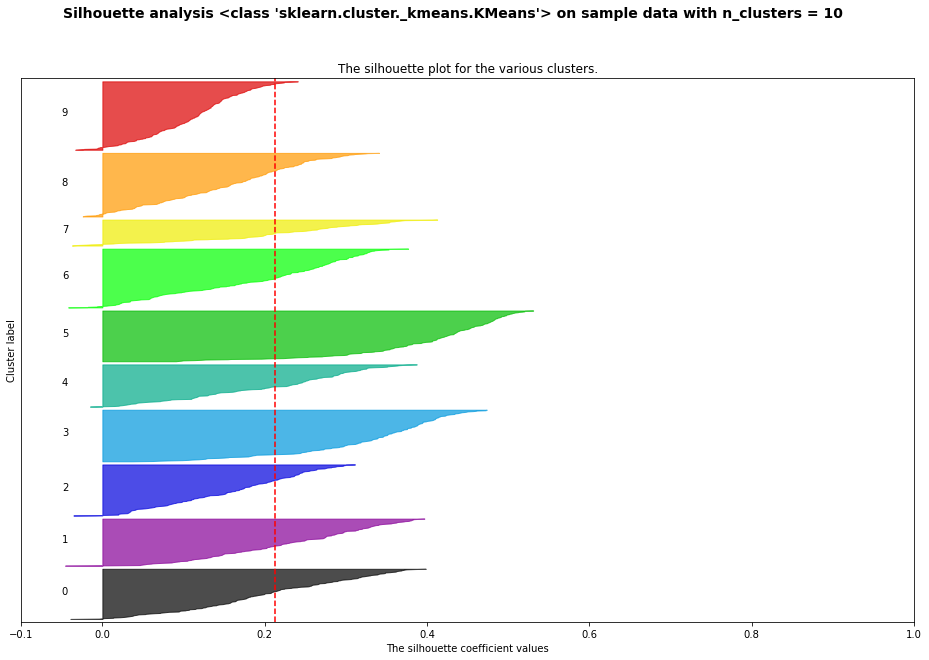

In [15]:
var = 0
n_componenents = [2,5,10,20]
for component in n_componenents:
    print(f'n_componenents = {component}')
    var = TruncatedSVD(n_components=component).fit_transform(X)
    print('homogeneity_completeness_v_measure:',homogeneity_completeness_v_measure(y,KMeans(10).fit_predict(var)))
    siluette_plot(KMeans,var,[10])
    print('\n')

n_componenents = 2
homogeneity_completeness_v_measure: (0.32793571798368754, 0.3397099051210441, 0.3337189903948925)
For n_clusters = 10 The average silhouette_score is : 0.28081683637254


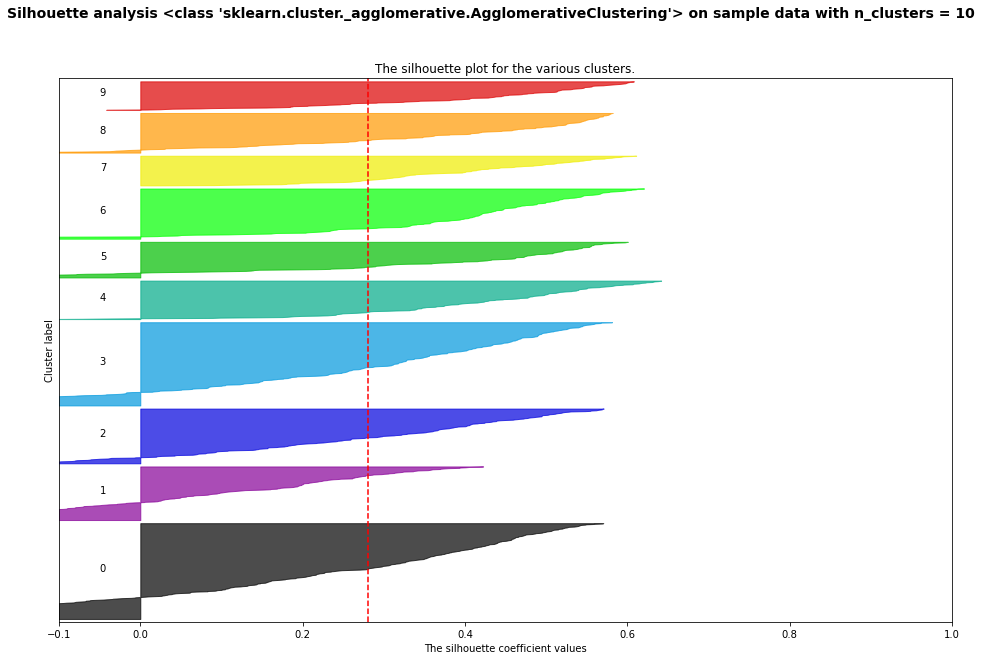



n_componenents = 5
homogeneity_completeness_v_measure: (0.6647373491711059, 0.6868311011608667, 0.6756036446423491)
For n_clusters = 10 The average silhouette_score is : 0.2727414461149832


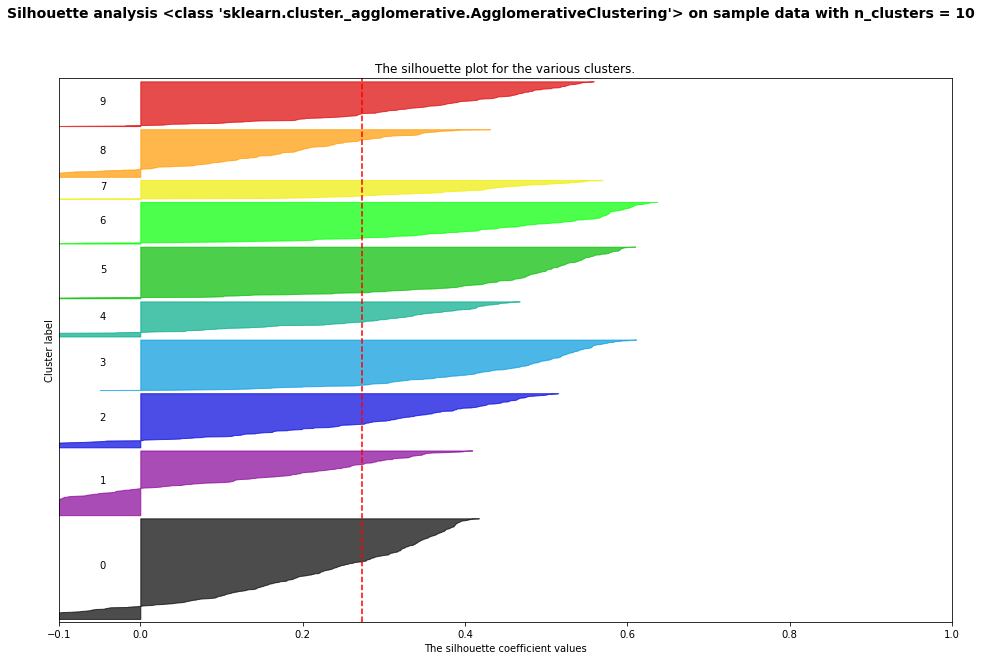



n_componenents = 10
homogeneity_completeness_v_measure: (0.8120777267597437, 0.8326713782189314, 0.8222456275125315)
For n_clusters = 10 The average silhouette_score is : 0.2505919767314866


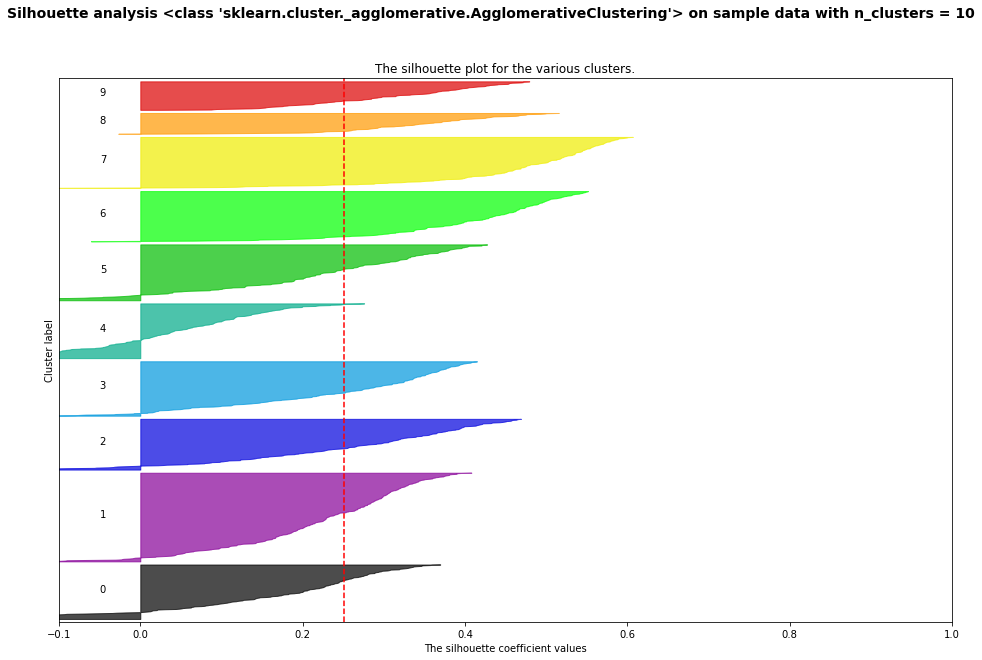



n_componenents = 20
homogeneity_completeness_v_measure: (0.8021399699368325, 0.8326932482280951, 0.8171311050922185)
For n_clusters = 10 The average silhouette_score is : 0.195658879474499


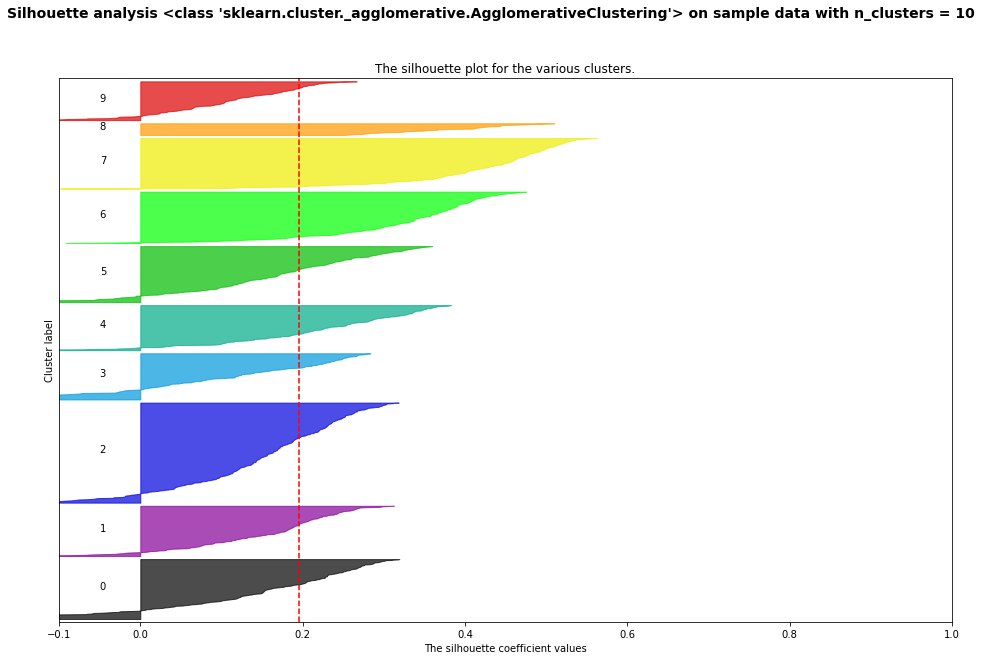

In [16]:
for component in n_componenents:
    print(f'n_componenents = {component}')
    var = TruncatedSVD(n_components=component).fit_transform(X)
    print('homogeneity_completeness_v_measure:',homogeneity_completeness_v_measure(y,AgglomerativeClustering(10).fit_predict(var)))
    siluette_plot(AgglomerativeClustering,var,[10])
    print('\n')

Значение силуэта улучшилось, но значение v-меры ухудшилось

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [17]:
X_embedded = TSNE(n_components=2).fit_transform(X)

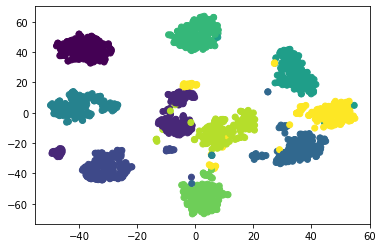

In [18]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y)

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

homogeneity_completeness_v_measure: (0.905170199224439, 0.9063800376887503, 0.9057747144630758)
For n_clusters = 10 The average silhouette_score is : 0.62961626


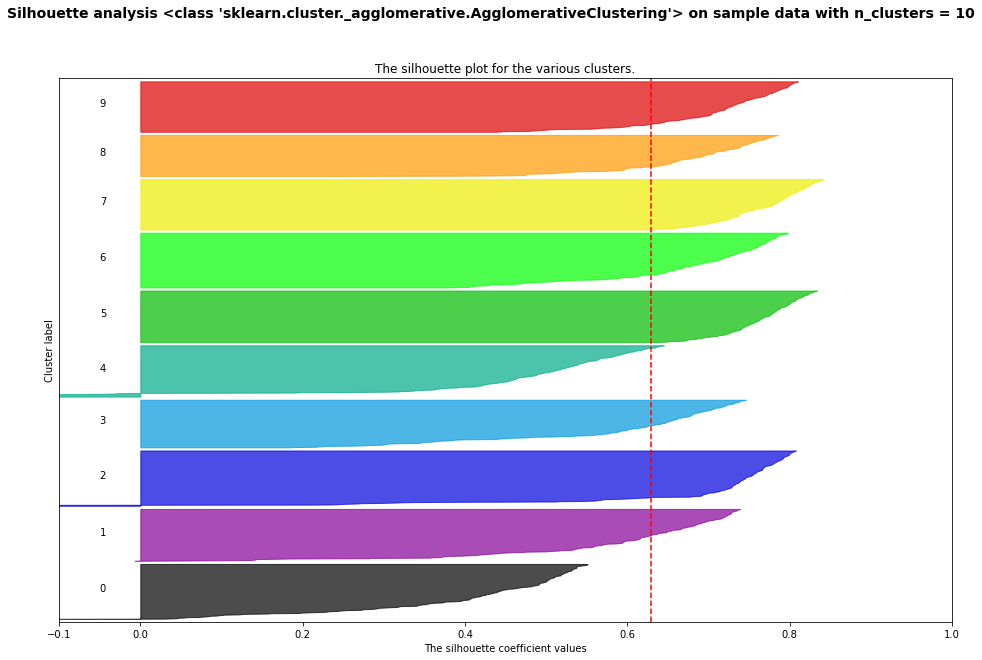

In [19]:
print('homogeneity_completeness_v_measure:',homogeneity_completeness_v_measure(y,AgglomerativeClustering(10).fit_predict(X_embedded)))
siluette_plot(AgglomerativeClustering,X_embedded,[10])

homogeneity_completeness_v_measure: (0.9026847238209085, 0.9039111891268944, 0.9032975401613392)
For n_clusters = 10 The average silhouette_score is : 0.62881047


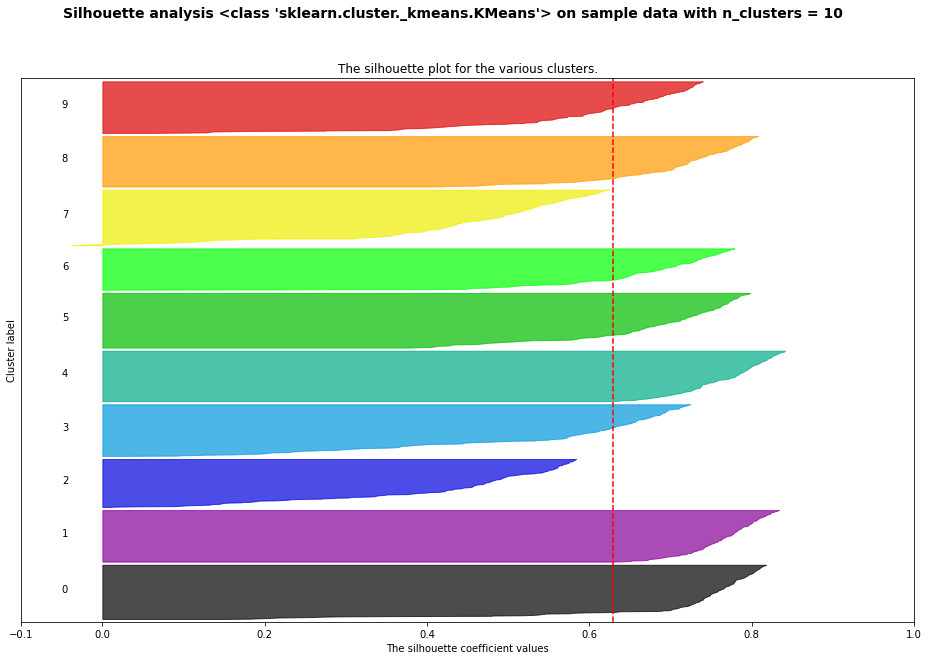

In [20]:
print('homogeneity_completeness_v_measure:',homogeneity_completeness_v_measure(y,KMeans(10).fit_predict(X_embedded)))
siluette_plot(KMeans,X_embedded,[10])

Обе метрики стали лучше

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

Лучшим разбиением явялется разбиеные после понижения размерности при момощи TSNE

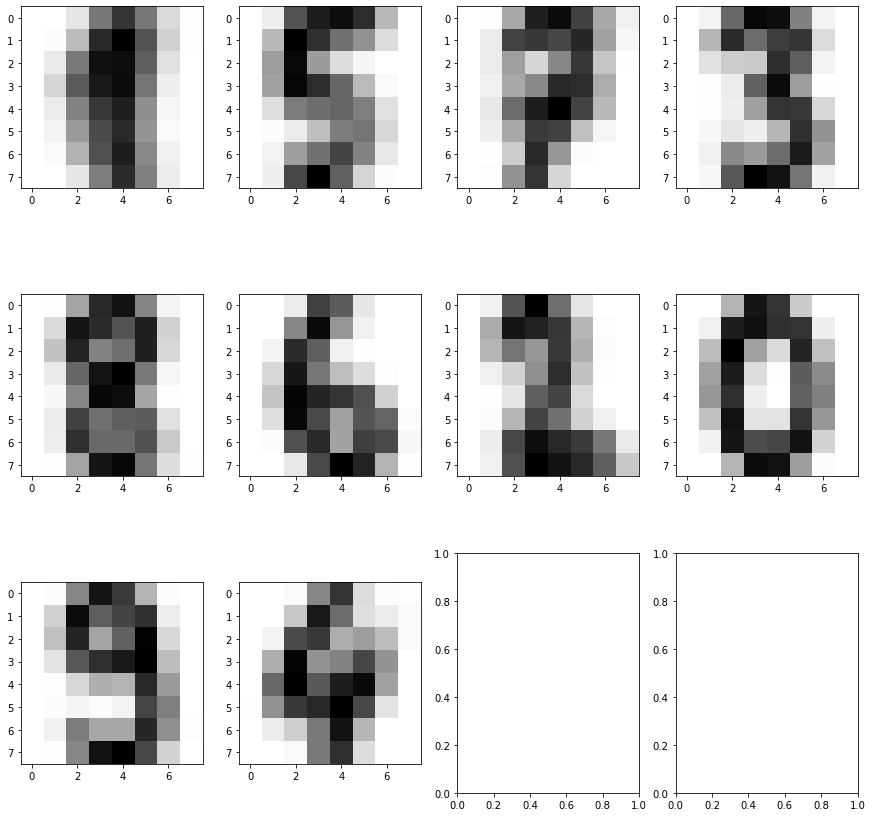

In [77]:
b[:,:-1] = X
b[:,-1] = AgglomerativeClustering(10).fit_predict(X_embedded)
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axs[0, 0].imshow(16 - np.mean(b[b[:,-1] == 0][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 1].imshow(16 - np.mean(b[b[:,-1] == 1][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 2].imshow(16 - np.mean(b[b[:,-1] == 2][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 3].imshow(16 - np.mean(b[b[:,-1] == 3][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 0].imshow(16 - np.mean(b[b[:,-1] == 4][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 1].imshow(16 - np.mean(b[b[:,-1] == 5][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 2].imshow(16 - np.mean(b[b[:,-1] == 6][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 3].imshow(16 - np.mean(b[b[:,-1] == 7][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 0].imshow(16 - np.mean(b[b[:,-1] == 8][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 1].imshow(16 - np.mean(b[b[:,-1] == 9][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
plt.show()

Тут можно перепутать 1 и 2

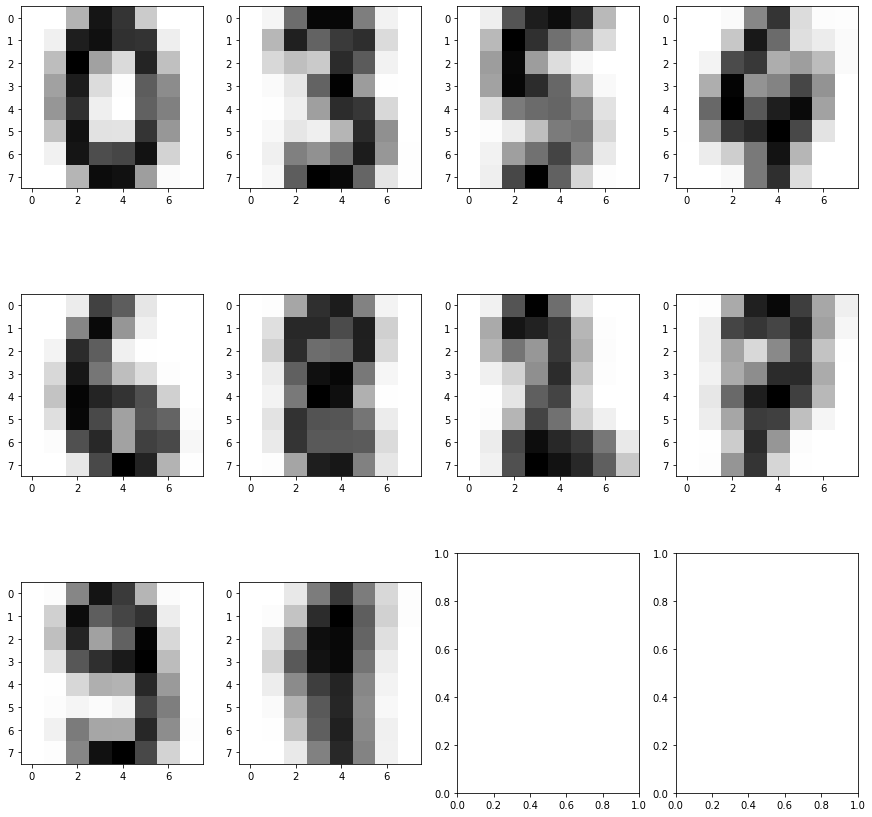

In [78]:
b[:,:-1] = X
b[:,-1] = KMeans(10).fit_predict(X_embedded)
fig, axs = plt.subplots(3, 4,figsize=(15,15))
axs[0, 0].imshow(16 - np.mean(b[b[:,-1] == 0][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 1].imshow(16 - np.mean(b[b[:,-1] == 1][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 2].imshow(16 - np.mean(b[b[:,-1] == 2][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[0, 3].imshow(16 - np.mean(b[b[:,-1] == 3][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 0].imshow(16 - np.mean(b[b[:,-1] == 4][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 1].imshow(16 - np.mean(b[b[:,-1] == 5][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 2].imshow(16 - np.mean(b[b[:,-1] == 6][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[1, 3].imshow(16 - np.mean(b[b[:,-1] == 7][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 0].imshow(16 - np.mean(b[b[:,-1] == 8][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
axs[2, 1].imshow(16 - np.mean(b[b[:,-1] == 9][:,:-1], axis=0).reshape((8, 8)), cmap='gray',interpolation=None)
plt.show()

Тут можно различить все.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

-  Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм  𝐾-средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?

Оба алогритма +- одинаково работали с датасетом digits, однако иерархическая кластеризация была немного лучше по метрикам и немного быстрее. 
Однако в задаче c mnist, метод К-средних отработал в разы быстрее. 
Соотвественно можно сделать вывод, что оба алгоритма имеют право на жизнь. 

- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

В данных задачах снижение размерности улучшило качество кластеризации, однако стоит учитывать что данные были разрежены, возможно на более "полных" данных снижение размерности ухудшит качество. 

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [119]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 1.1 MB 7.0 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=6a4c2108d3244ace5e15a85e5ba5df05c1f67cf323833fc59698db672cc115a5
  Stored in directory: /Users/daniilkaratsetski/Library/Caches/pip/wheels/95/85/b7/b4b7040e49367b6d1505d7e8fb57e3e79b22fa6ac26f72520b
  Created wheel for pynndescent: filename=pynndescent-0.5.2-py3-none-any.whl size=51349 sha256=e44a0ff18ac562e6fe0d38ee3f2b7f108192aab0f7e38a14e2775260e1e674be
  Stored in directory: /Users/daniilkaratsetski/Library/Caches/pip/wheels/bb/81/5d/c78c8f15f3c815197129f91ec435d8ae0bb0a7a856d962c3ce
Successfully built umap-learn pynndescent


In [21]:
import umap

In [22]:
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [23]:
X_mnist.shape

(70000, 784)

In [24]:
X_svd = TruncatedSVD(n_components=700).fit_transform(X_mnist)

In [25]:
embedding = umap.UMAP().fit_transform(X_svd)

In [26]:
embedding.shape

(70000, 2)

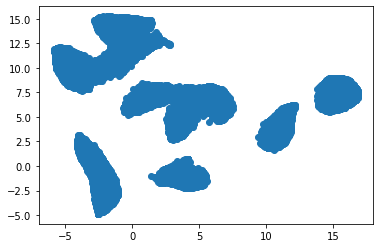

In [27]:
plt.scatter(embedding[:,0],embedding[:,1])

Снижение размерности произошло удачно, можно увидеть 10 кластеров. Кластеризация должна пройти достаточно удачно

In [28]:
y_km = KMeans(10).fit_predict(embedding)

К сожалению англомеративная кластеризация очень долго выполняется, поэтому будем использовать KMeans. 

In [29]:
print('homogeneity_completeness_v_measure:',homogeneity_completeness_v_measure(y_mnist,y_km))

homogeneity_completeness_v_measure: (0.8330928219686959, 0.8521486014085473, 0.8425129755728867)


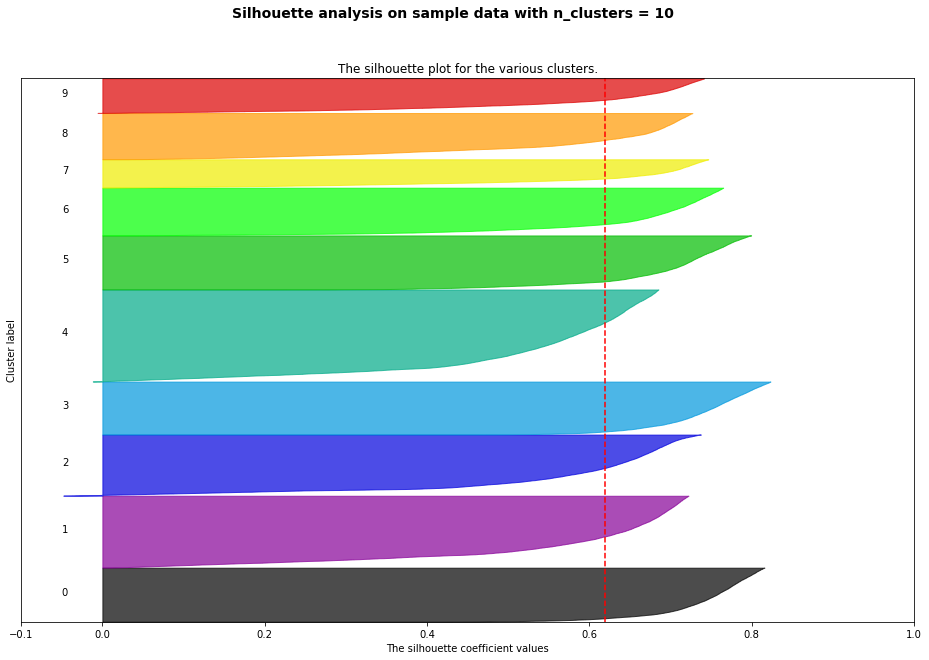

In [24]:
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(16, 10)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(embedding) + (10 + 1) * 10])
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(embedding, y_km)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(embedding, y_km)

        y_lower = 10
        for i in range(10):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[y_km == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / 10)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis on sample data "
                      f"with n_clusters = {10}"),
                     fontsize=14, fontweight='bold')

        plt.show()

Метрики показывают, что кластеризация прошла достаточно хорошо. 

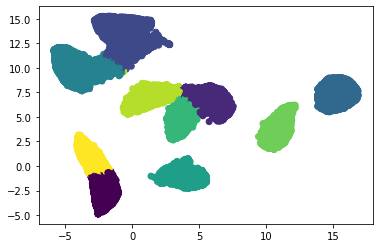

In [30]:
plt.scatter(embedding[:,0],embedding[:,1],c=y_km)

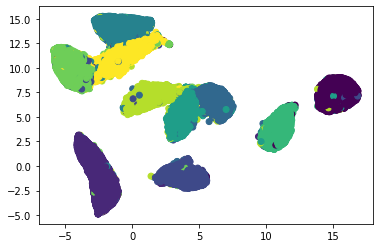

In [39]:
plt.scatter(embedding[:,0],embedding[:,1],c=list(map(int,y_mnist)))

Алгоритм ошибся только с желтым кластером, остальные выделил правильно